In [1]:
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans
from pathlib import Path
import skimage as ski
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import shape, Point
import math
from sklearn.calibration import calibration_curve
from scipy.signal import fftconvolve as scipy_fft_conv
import rasterio
import rasterio.features
import rasterio.warp
import pickle
import json
import warnings
from sklearn.metrics import log_loss
import cv2
import random
from train.variables import variables, topvariables
random.seed(42)

In [2]:
from scipy import stats

def freedman_diaconis(data, returnas="bins"):
    """
    Utilise la règle de Freedman Diaconis pour calculer la largeur optimale des bins de l'histogramme.
    ``returnas`` peut être "width" ou "bins", indiquant si la largeur ou le nombre de
    la largeur de l'histogramme ou le nombre d'histogrammes doit être retourné.

    Parameteres
    ----------
    - data: np.ndarray One-dimensional array.
    - returnas : {"width", "bins"}
      Si "width", la largeur estimée de chaque cellule de l'histogramme est renvoyée.
      Si "bins", renvoie le nombre de bins suggéré par rule.ively.
    """
    data = np.asarray(data, dtype=np.float_)
    IQR  = max(stats.iqr(data, rng=(25, 75), scale="raw", nan_policy="omit"), np.min(data))
    N    = data.size
    bw   = (2 * IQR) / np.power(N, 1/3)

    if returnas=="width":
        result = bw
    else:
        datmin, datmax = data.min(), data.max()
        datrng = datmax - datmin
       
        result = int((datrng / bw) + 1)
    return result

def expected_calibration_error(y, proba, bins):
    """
    Calcule l'erreur de calibration : expected_calibration_error (ECE)
    """
    bin_count, bin_edges = np.histogram(proba, bins = bins)
    n_bins = len(bin_count)
    bin_edges[0] -= 1e-8 # because left edge is not included
    bin_id = np.digitize(proba, bin_edges, right = True) - 1
    bin_ysum = np.bincount(bin_id, weights = y, minlength = n_bins)
    bin_probasum = np.bincount(bin_id, weights = proba, minlength = n_bins)
    bin_ymean = np.divide(bin_ysum, bin_count, out = np.zeros(n_bins), where = bin_count > 0)
    bin_probamean = np.divide(bin_probasum, bin_count, out = np.zeros(n_bins), where = bin_count > 0)
    ece = np.abs((bin_probamean - bin_ymean) * bin_count).sum() / len(proba)
    return n_bins, ece

def expected_calibration_error(true_labels, samples, bins=5):
    
    bin_count, bin_edges = np.histogram(samples, bins = 'auto')
    n_bins = len(bin_count)
    # uniform binning approach with M number of bins
    bin_boundaries = bin_edges
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    confidences = samples

    # get a boolean list of correct/false predictions
    accuracies = true_labels

    ece = np.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # determine if sample is in bin m (between bin lower & upper)
        in_bin = np.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item())
        # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
        prob_in_bin = in_bin.mean()

        if prob_in_bin.item() > 0:
            # get the accuracy of bin m: acc(Bm)
            accuracy_in_bin = accuracies[in_bin].mean()
            # get the average confidence of bin m: conf(Bm)
            avg_confidence_in_bin = confidences[in_bin].mean()
            # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prob_in_bin
    return n_bins, ece[0] * 100

In [3]:
version = 'GMClustering'

sinister = 'NATURELSFire'

dir_csv = Path(version)

dataset = pd.read_csv(dir_csv / 'dataset_2023_calibrated.csv')

config = json.load(open(dir_csv / 'config.json', 'rb'))
#dataset = dataset[dataset['year'] > 2017]

In [7]:
dataset['temp_mean_0'].mean()

15.167139495829046

In [4]:
topo = dataset[topvariables]
topo['cluster'] = dataset['cluster']

/tmp/ipykernel_15334/1710889994.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topo['cluster'] = dataset['cluster']


In [4]:
len(dataset[dataset['isNATURELSFire'] > 0])

6807

<Axes: >

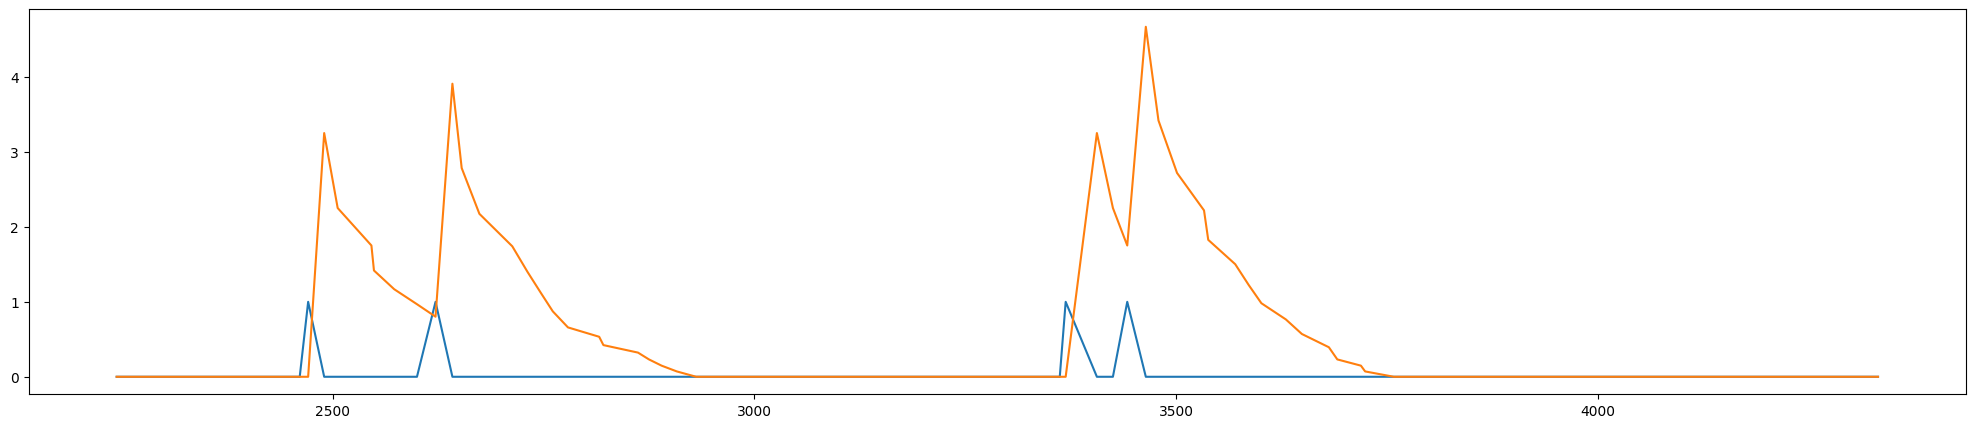

In [24]:
fig, ax = plt.subplots(1, figsize=(25,5))

dataset[dataset['cluster'] == 0]['isNATURELSFire'][:100].plot(ax=ax)
dataset[dataset['cluster'] == 0]['influenceNATURELSFirebefore'][:100].plot(ax=ax)

In [5]:
topo.groupby('cluster')[topvariables].mean()

,NDVI_mean,NDVI_max,NDVI_min,NDVI_std,NDMI_mean,NDMI_max,NDMI_min,NDMI_std,NDSI_mean,NDSI_max,...,NDWI_min,NDWI_std,population_mean,population_max,population_min,population_std,elevation_mean,elevation_max,elevation_min,elevation_std
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.633907,0.967421,-0.878174,0.216346,0.145225,0.850087,-0.835889,0.170787,-0.513572,0.932445,...,-0.924858,0.208148,82.242631,416.0,24.0,NaN,342.508751,1525.0,0.0,NaN
1,0.647414,0.977724,-0.918315,0.214930,0.185118,0.949462,-0.913409,0.190916,-0.501059,0.956240,...,-0.947047,0.181472,37.018833,209.0,24.0,NaN,340.520054,1274.0,0.0,NaN
2,0.629551,0.967959,-0.727277,0.199300,0.213982,0.848453,-0.774803,0.198089,-0.454634,0.912318,...,-0.926937,0.170270,72.684715,901.0,30.0,NaN,456.189515,1710.0,0.0,NaN
3,0.600716,0.966341,-0.799452,0.232115,0.143613,0.918230,-0.775938,0.182481,-0.498328,0.930588,...,-0.914010,0.184480,264.847666,1000.0,30.0,NaN,79.082124,570.0,0.0,NaN
4,0.673556,0.959639,-0.839294,0.204197,0.198494,0.767476,-0.838488,0.174806,-0.513128,0.879203,...,-0.908570,0.185938,36.294173,209.0,51.0,NaN,277.988219,1095.0,0.0,NaN
5,0.514397,0.963325,-0.785836,0.251149,0.098501,0.912645,-0.745685,0.196352,-0.464417,0.923163,...,-0.905851,0.204791,20.396274,169.0,24.0,NaN,88.480192,319.0,0.0,NaN
6,0.519724,0.954923,-0.691860,0.256291,0.109220,0.802853,-0.678185,0.190111,-0.466404,0.830528,...,-0.895815,0.216826,22.440032,152.0,30.0,NaN,82.459662,290.0,0.0,NaN
240,0.697936,0.963744,-0.640546,0.171116,0.190445,0.803351,-0.750022,0.164831,-0.550164,0.799038,...,-0.920938,0.126464,65.358148,184.0,19.0,41.330591,NaN,NaN,NaN,NaN
241,0.612448,0.956885,-0.750989,0.217098,0.130816,0.746242,-0.761381,0.164290,-0.521374,0.901195,...,-0.902432,0.185691,45.838847,72.0,28.0,11.366018,NaN,NaN,NaN,NaN


In [ ]:
dataset.cluster.unique()

array([244, 772, 247, 246, 245, 770, 242, 241, 240, 771, 243, 682, 681,
       680,   0,   3,   4,   5,   6,   2,   1])

Text(0, 0.5, 'Samples')

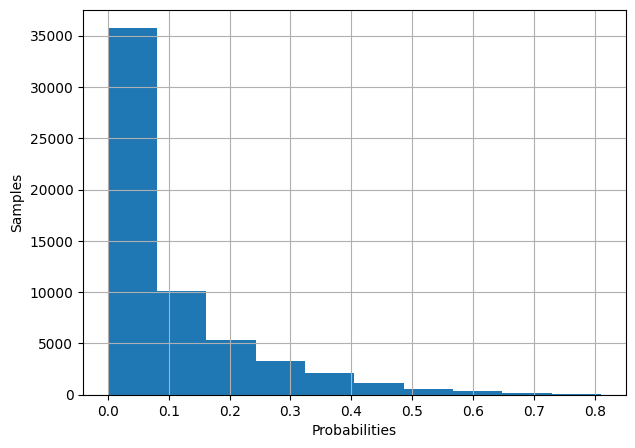

In [ ]:
fig, ax = plt.subplots(1, figsize=(7,5))

dataset.calibratedProbaFor1NATURELSFire.hist(ax=ax)
ax.set_xlabel('Probabilities')
ax.set_ylabel('Samples')

In [ ]:
dataset.cluster.unique()

array([240, 241, 242, 243, 244, 245, 246, 247, 771, 772, 770,   0, 682,
       681,   6,   5,   4,   3,   2,   1, 680])

Text(0, 0.5, 'Occurences')

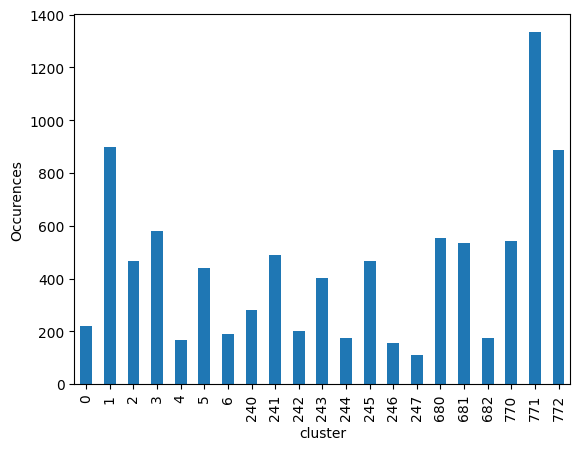

In [ ]:
fig, ax = plt.subplots(1)

dataset.groupby('cluster')['nb'+sinister].sum().plot.bar(ax=ax)
ax.set_ylabel('Occurences')

Text(0, 0.5, 'Occurences')

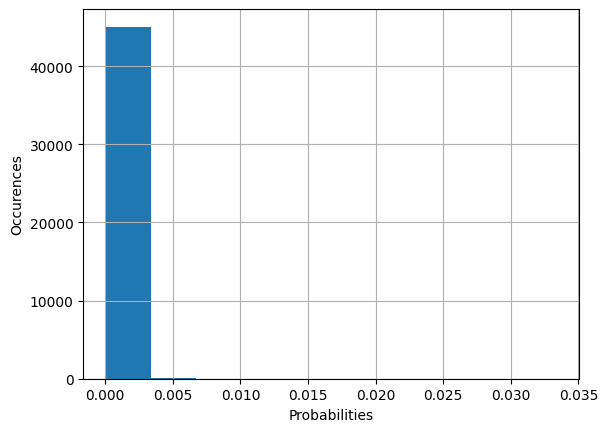

In [ ]:
fig, ax = plt.subplots(1)
dataset[dataset['calibratedProbaFor10'+sinister+'test'] >= 0]['calibratedProbaFor10'+sinister+'test'].hist()
ax.set_xlabel('Probabilities')
ax.set_ylabel('Occurences')

Text(0, 0.5, 'Occurences')

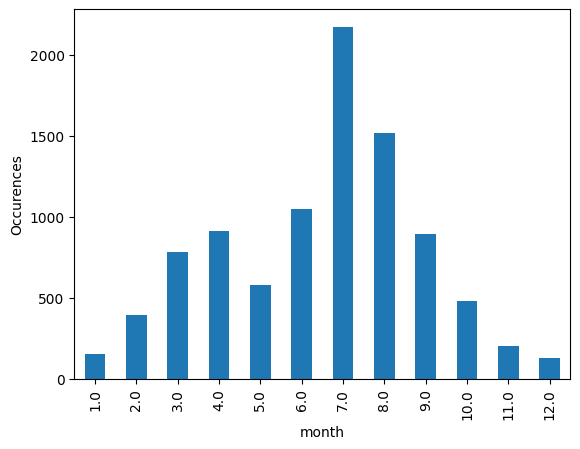

In [ ]:
fig, ax = plt.subplots(1)

dataset.groupby('month')['nb'+sinister].sum().plot.bar(ax=ax)
ax.set_ylabel('Occurences')

In [ ]:
test = pd.read_csv(dir_csv/'test_2023.csv')

In [ ]:
#dataset.dropna(subset=variables)

In [127]:
import numpy as np

Ain = np.arange(0,10)
Doubs = np.arange(240,250)
rhone = np.arange(680,690)                        
Yvelines = np.arange(770,780)

In [128]:
dataset['nb'+sinister].max()

11.0

In [129]:
dataset[dataset['nb'+sinister] == dataset['nb'+sinister].max()][['departement', 'influence'+sinister+'test' ,'calibratedProbaFor1'+sinister+'test', 'calibratedProbaFor5'+sinister+'test']]

,departement,influenceNATURELSFiretest,calibratedProbaFor1NATURELSFiretest,calibratedProbaFor5NATURELSFiretest
11134,1,28.397492,0.875650,0.14629
21648,78,48.002994,0.984962,0.29767


In [130]:
dataset[dataset['is'+sinister] > 0]['nb'+sinister].quantile((0.05,0.2,0.5,0.75,0.90))

0.05    1.0
0.20    1.0
0.50    1.0
0.75    2.0
0.90    2.0
Name: nbNATURELSFire, dtype: float64

Text(0, 0.5, 'Fire influence')

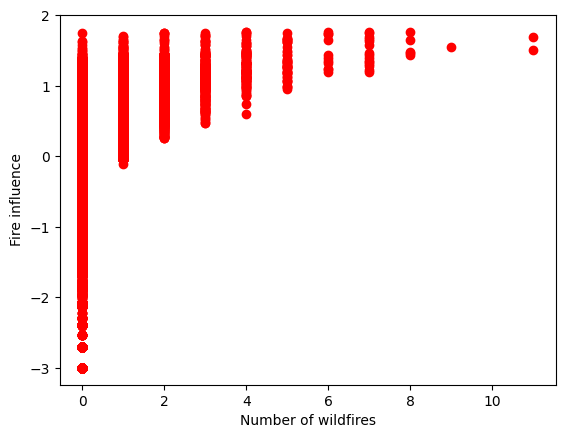

In [15]:
plt.scatter(dataset['nb'+sinister], dataset['logInfluence'+sinister+'test'], c='red')
plt.xlabel('Number of wildfires')
plt.ylabel('Fire influence')

In [13]:
len(dataset[dataset['nb'+sinister] >= 10])

2

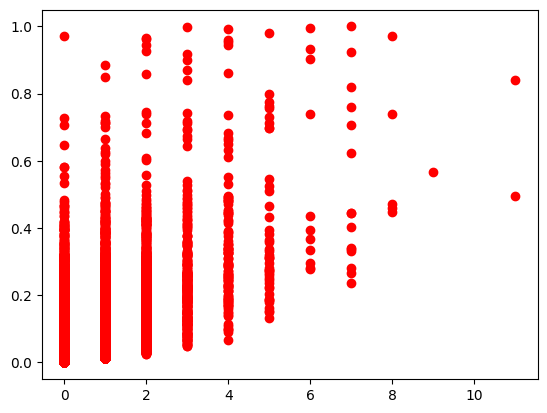

In [132]:
from sklearn.preprocessing import MinMaxScaler
dataset['influence'+sinister+'testScale'] = MinMaxScaler().fit_transform(dataset['influence'+sinister+'test'].values.reshape(-1,1))

plt.scatter(dataset['nb'+sinister], dataset['influence'+sinister+'testScale'], c='red')

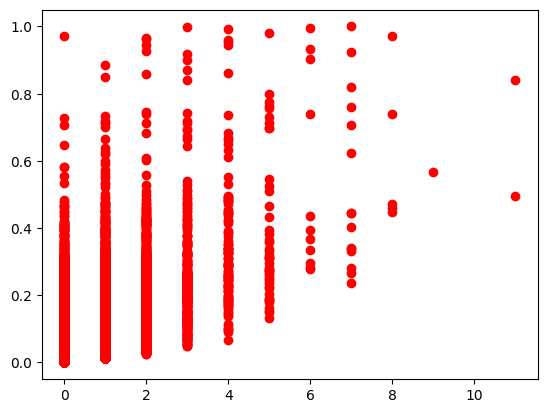

In [133]:
plt.scatter(dataset['nb'+sinister], dataset['logInfluence'+sinister+'test'], c='red')

[0 6 5 4 3 2 1]


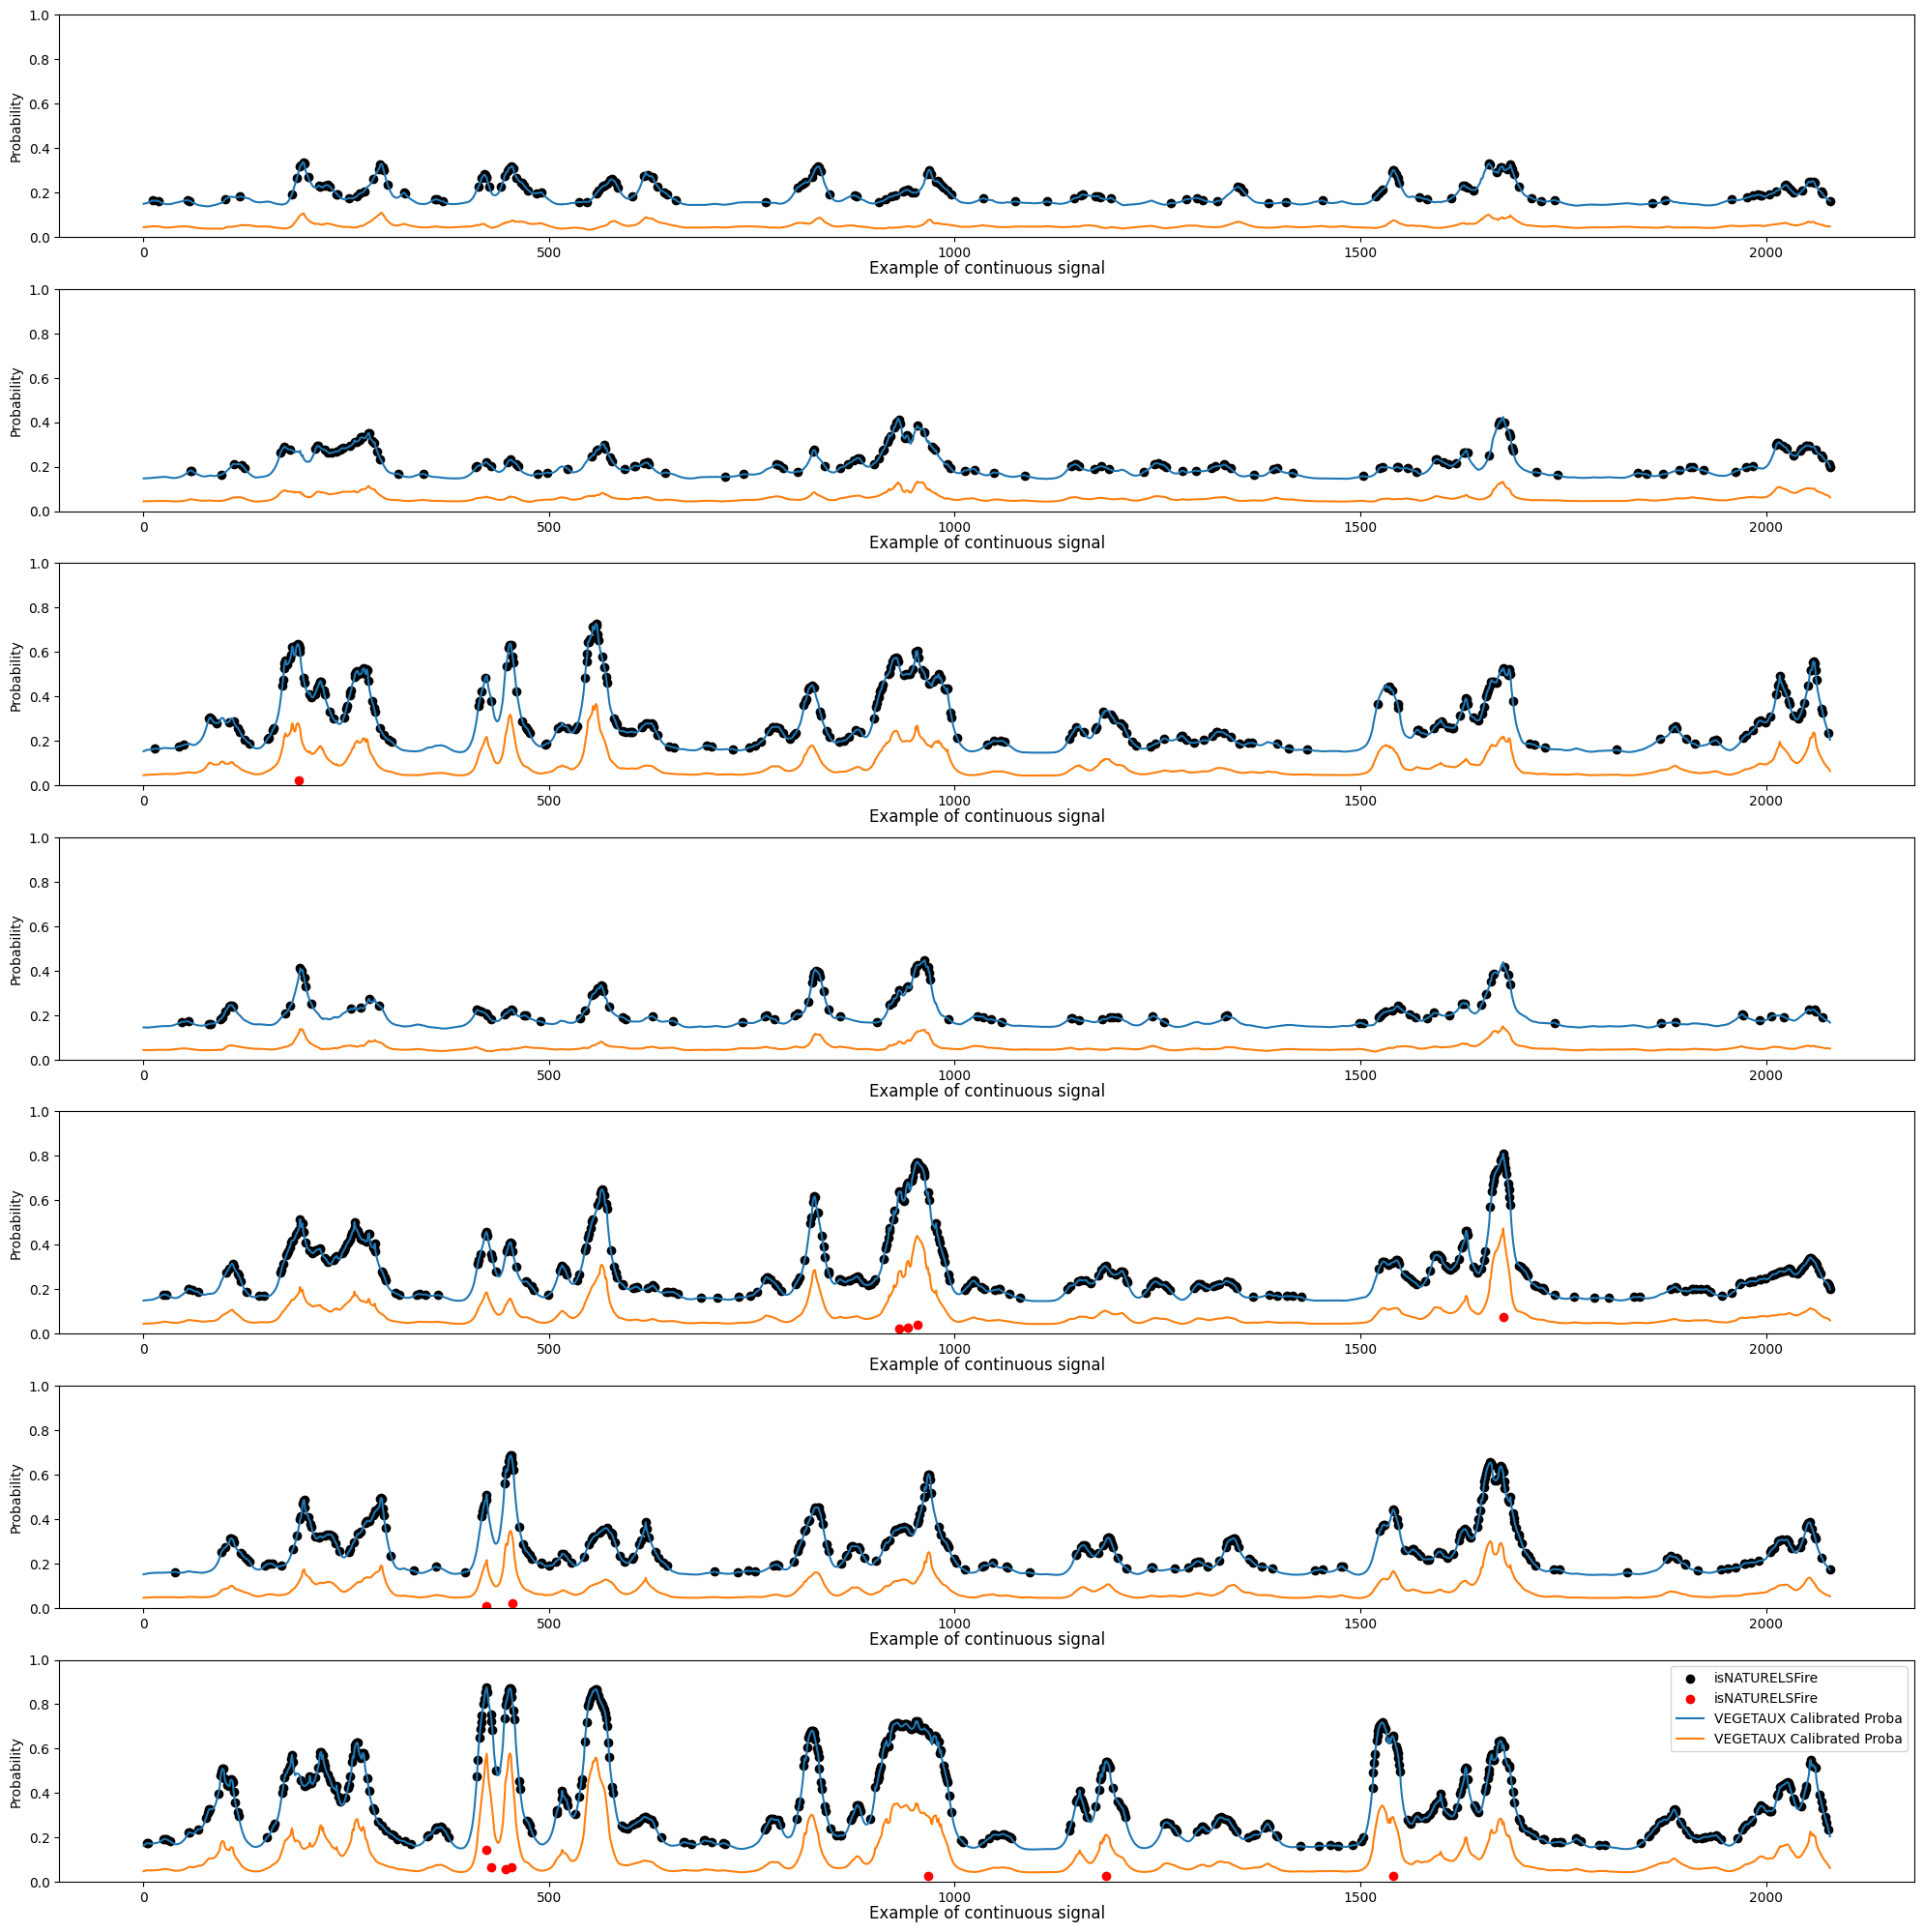

In [139]:
dataset252 = dataset[(dataset['cluster'].isin(Ain))]
#print(dataset252[dataset252['creneau'] >= '2017-06-05']['nbFire'].sum())
clusterId = dataset252['cluster'].unique()

print(clusterId)
if len(clusterId) > 1:

    fig, ax = plt.subplots(len(clusterId), figsize = (20,20))

    for i, cID in enumerate(clusterId):
        dataset252_ = dataset252[(dataset252['cluster'] == cID)].reset_index(drop=True)
        #dataset252_Fire = dataset252_[dataset252_['isAGRICOLEFire'] > 0]
        #ax[i].scatter(dataset252_Fire.index.values, dataset252_Fire.calibratedProbaAGRICOLEFiretest, label='isAGRICOLEFire', color='black')
        dataset252_Fire = dataset252_[dataset252_['is1'+sinister] > 0]
        ax[i].scatter(dataset252_Fire.index.values, dataset252_Fire['calibratedProbaFor1'+sinister+'test'], label='isNATURELSFire', color='black')
        dataset252_Fire = dataset252_[dataset252_['is5'+sinister] > 0]
        ax[i].scatter(dataset252_Fire.index.values, dataset252_Fire['calibratedProbaFor5'+sinister+'test'], label='isNATURELSFire', color='red')
        #ax[i].plot(dataset252_.index.values, dataset252_.isNATURELSFire.values, label='influence')
        ax[i].plot(dataset252_.index.values, dataset252_['calibratedProbaFor1'+sinister+'test'].values, label='VEGETAUX Calibrated Proba')
        ax[i].plot(dataset252_.index.values, dataset252_['calibratedProbaFor2'+sinister+'test'].values, label='VEGETAUX Calibrated Proba')
        #ax[i].plot(dataset252_.index.values, dataset252_.calibratedProbaFORETFiretest.values, label='FORET Calibrated Proba')
        #ax[i].plot(dataset252_.index.values, dataset252_.calibratedProbaAGRICOLEFiretest.values, label='AGRICOLE Calibrated Proba')
        #ax[i].plot(dataset252_.index.values, dataset252_.classCalibratedProba.values, label='Calibrated Proba')
        #ax[i].plot(dataset252_.index.values, dataset252_.fireInfluence.values, label='Fire Influence')
        ax[i].set_ylabel('Probability')
        ax[i].set_ylim([0, 1])
        ax[i].set_title('Example of continuous signal', y=-0.2)
    plt.legend()
    plt.tight_layout()
    plt.savefig(dir_csv/'ain.png')

else:
    fig, ax = plt.subplots(1, figsize = (20,5))

    dataset252_ = dataset[(dataset['departement'] == 1)].reset_index(drop=True)
    ax.plot(dataset252_.index.values, dataset252_.isFire.values, label='IsFire')
    ax.plot(dataset252_.index.values, dataset252_.calibratedProbaNATURELSFiretest.values, label='Calibrated Proba')
    #ax.plot(dataset252_.index.values, dataset252_.calibratedProbaAGRICOLEFiretest.values, label='AGRICOLE Calibrated Proba')
    #ax[i].plot(dataset252_.index.values, dataset252_.classCalibratedProba.values, label='Calibrated Proba')
    #ax[i].plot(dataset252_.index.values, dataset252_.fireInfluence.values, label='Fire Influence')
    plt.legend()
    plt.savefig(dir_csv/'ain.png')

In [135]:
dataset[dataset['nbInondation'] > 0]['nbInondation'].max(), dataset[dataset['nbInondation'] > 0]['nbInondation'].mean(), dataset[dataset['nbInondation'] > 0]['nbInondation'].min()

(204.0, 21.342960288808666, 1.0)

In [136]:
dataset[dataset['nbInondation'] > 0]['nbInondation'].quantile([0.05,0.5,0.95])

0.05     3.0
0.50    12.0
0.95    67.6
Name: nbInondation, dtype: float64

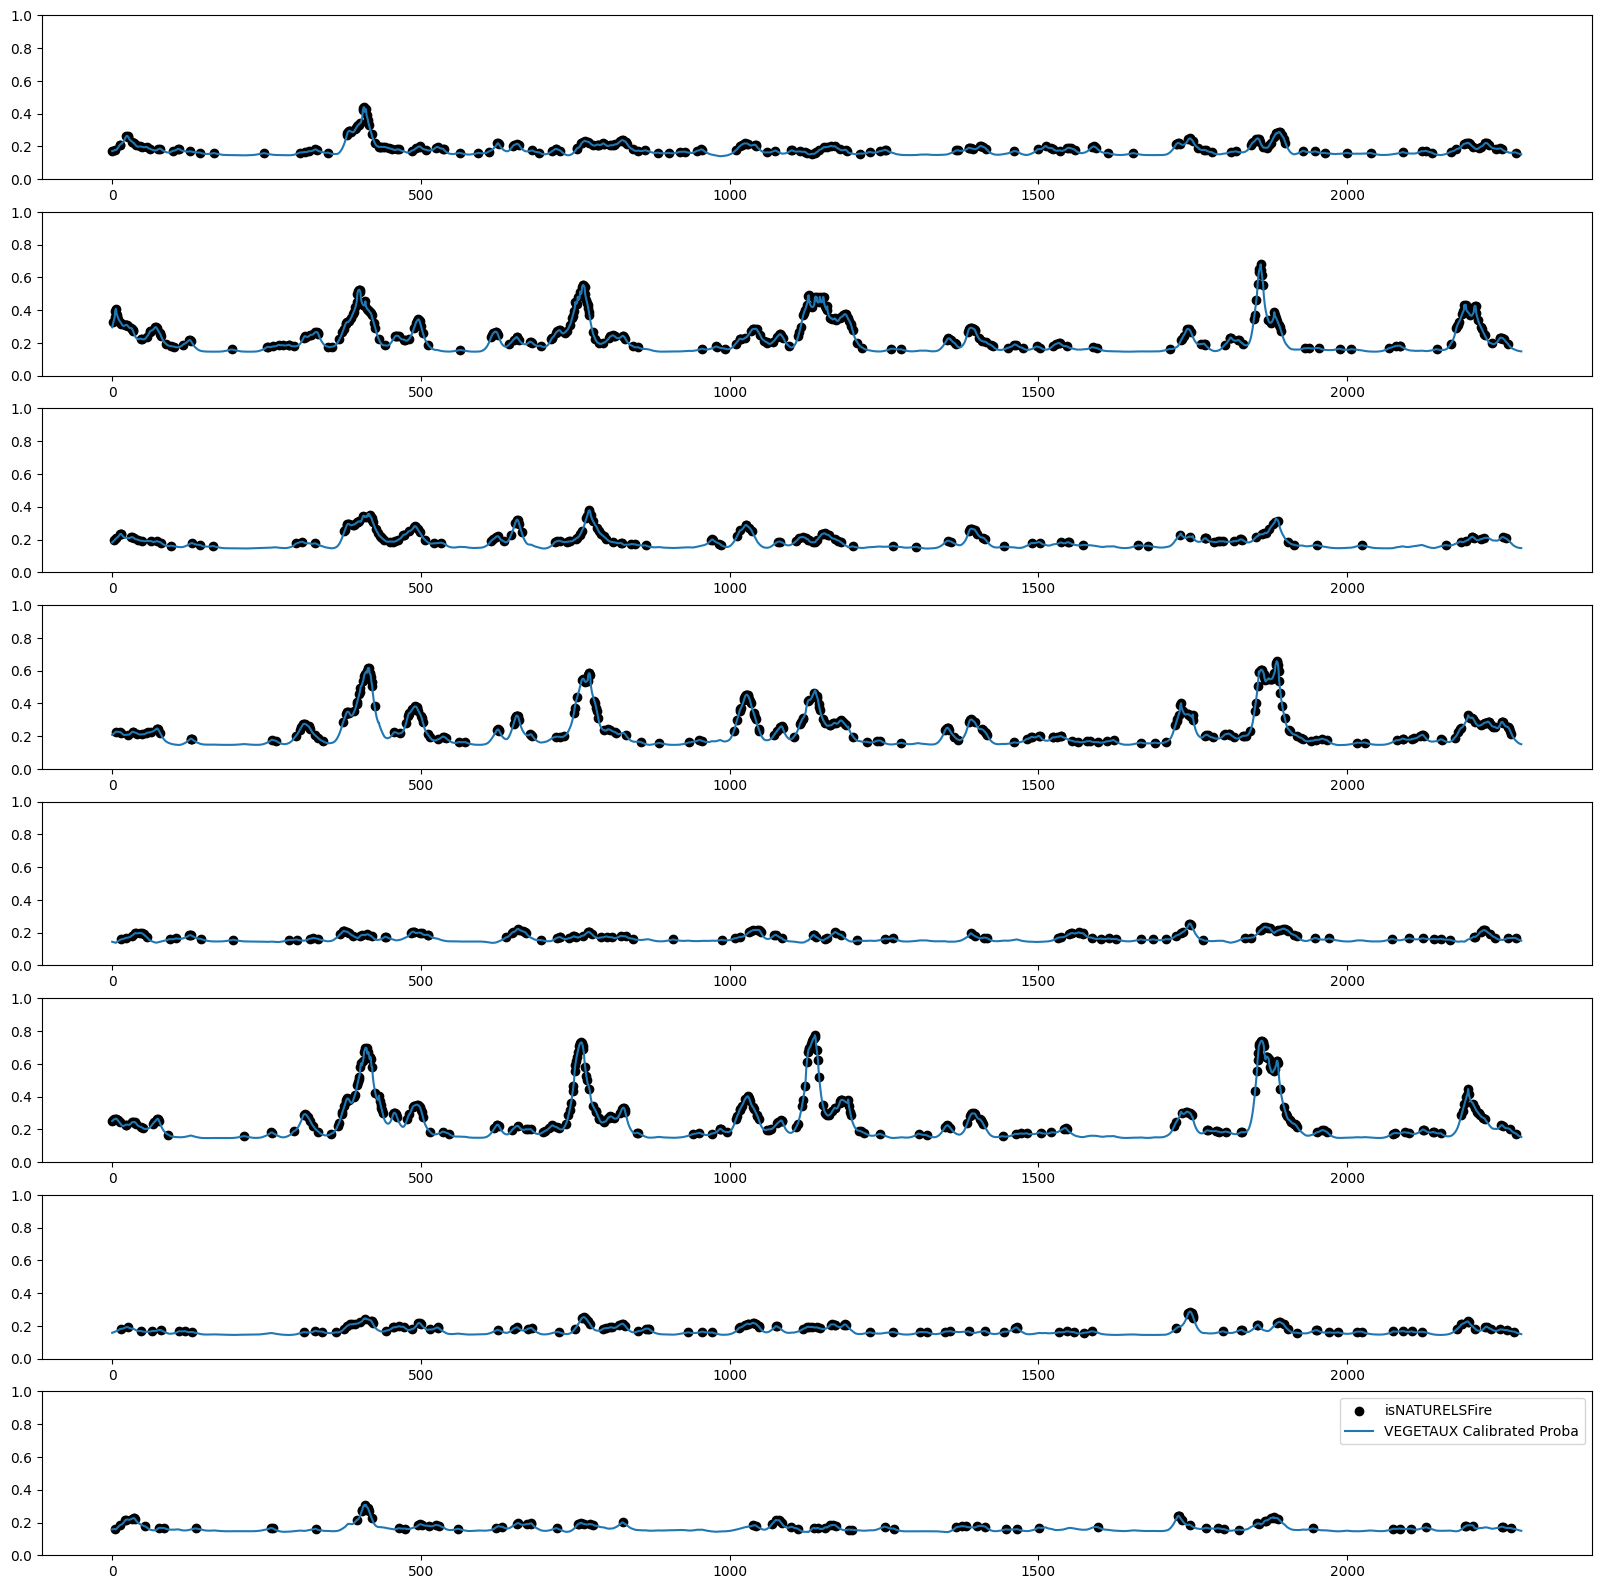

In [137]:
dataset252 = dataset[(dataset['cluster'].isin(Doubs))]
#print(dataset252[dataset252['creneau'] >= '2017-06-12']['nbFire'].sum())

clusterId = dataset252['cluster'].unique()

if len(clusterId) > 1:

    fig, ax = plt.subplots(len(clusterId), figsize = (20,20))

    for i, cID in enumerate(clusterId):
        dataset252_ = dataset252[(dataset252['cluster'] == cID)].reset_index(drop=True)
        #dataset252_Fire = dataset252_[dataset252_['isAGRICOLEFire'] > 0]
        #ax[i].scatter(dataset252_Fire.index.values, dataset252_Fire.calibratedProbaAGRICOLEFiretest, label='isAGRICOLEFire', color='black')
        dataset252_Fire = dataset252_[dataset252_['is1'+sinister] > 0]
        ax[i].scatter(dataset252_Fire.index.values, dataset252_Fire['calibratedProbaFor1'+sinister+'test'], label='isNATURELSFire', color='black')
        #ax[i].plot(dataset252_.index.values, dataset252_.influenceNATURELSFirebefore.values, label='influence')
        ax[i].plot(dataset252_.index.values, dataset252_['calibratedProbaFor1'+sinister+'test'].values, label='VEGETAUX Calibrated Proba')
        #ax[i].plot(dataset252_.index.values, dataset252_['influence'+sinister].values, label='VEGETAUX Calibrated Proba')
        #ax[i].plot(dataset252_.index.values, dataset252_.calibratedProbaFORETFiretest.values, label='FORET Calibrated Proba')
        #ax[i].plot(dataset252_.index.values, dataset252_.calibratedProbaAGRICOLEFiretest.values, label='AGRICOLE Calibrated Proba')
        #ax[i].plot(dataset252_.index.values, dataset252_.classCalibratedProba.values, label='Calibrated Proba')
        #ax[i].plot(dataset252_.index.values, dataset252_.fireInfluence.values, label='Fire Influence')
        ax[i].set_ylim([0, 1])
    plt.legend()
    plt.savefig(dir_csv/'doubs.png')

else:
    fig, ax = plt.subplots(1, figsize = (20,5))

    dataset252_ = dataset[(dataset['departement'] == 25)].reset_index(drop=True)
    ax.plot(dataset252_.index.values, dataset252_.isFire.values, label='IsFire')
    ax.plot(dataset252_.index.values, dataset252_.calibratedProbaNATURELSFiretest.values, label='Calibrated Proba')
    ax.plot(dataset252_.index.values, dataset252_.calibratedProbaAGRICOLEFiretest.values, label='AGRICOLE Calibrated Proba')
    #ax[i].plot(dataset252_.index.values, dataset252_.fireInfluence.values, label='Fire Influence')
    plt.legend()
    plt.savefig(dir_csv/'doubs.png')

KeyError: 'calibratedProbaNATURELSFiretest'

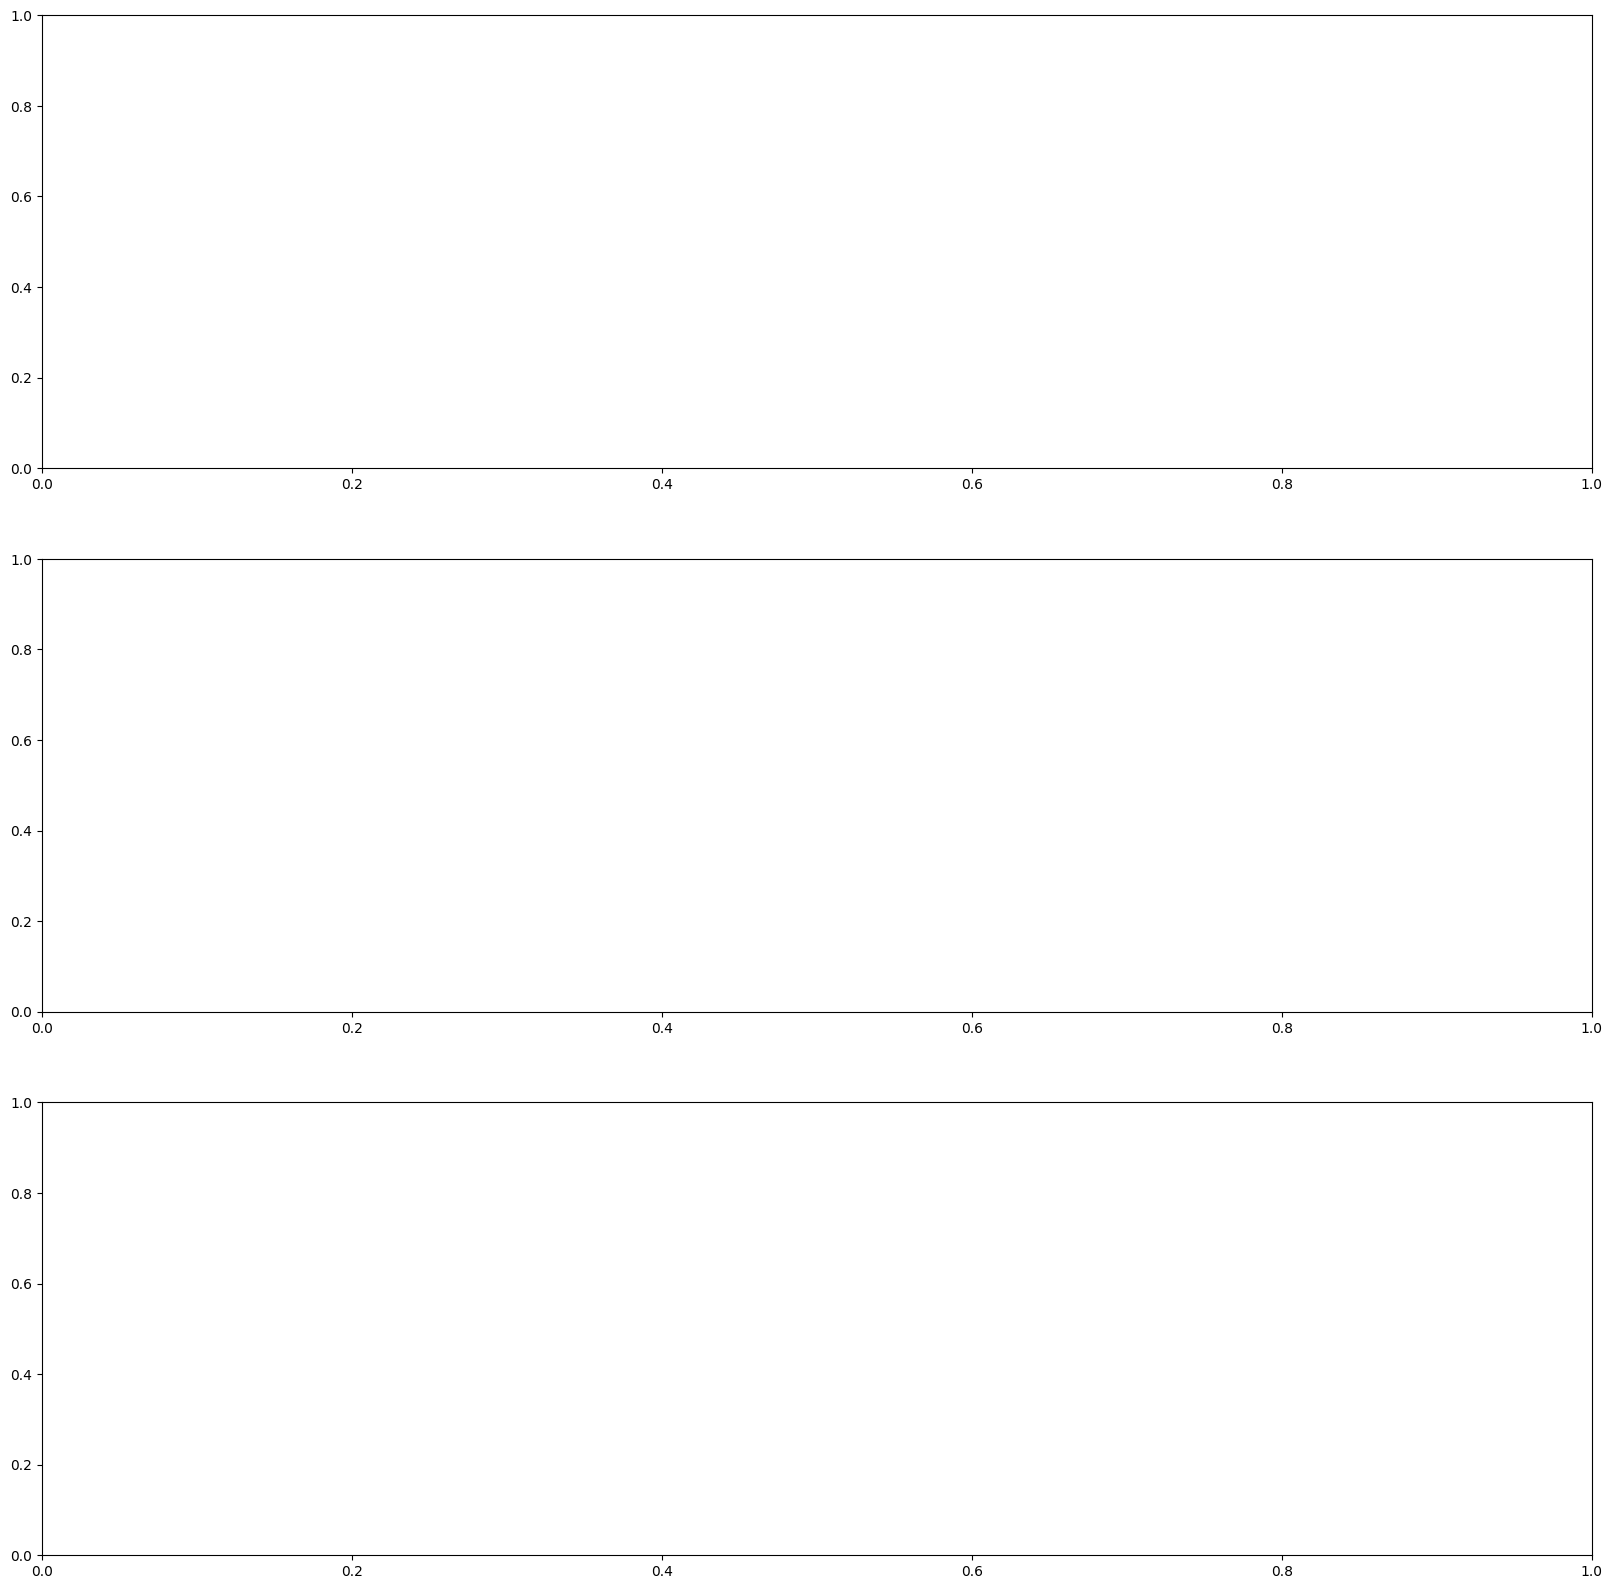

In [138]:
dataset252 = dataset[(dataset['cluster'].isin(rhone))]
#print(dataset252[dataset252['creneau'] >= '2017-06-12']['nbFire'].sum())
clusterId = dataset252['cluster'].unique()

if len(clusterId) > 1:

    fig, ax = plt.subplots(len(clusterId), figsize = (20,20))

    for i, cID in enumerate(clusterId):
        dataset252_ = dataset252[(dataset252['cluster'] == cID)].reset_index(drop=True)
        #dataset252_Fire = dataset252_[dataset252_['isAGRICOLEFire'] > 0]
        #ax[i].scatter(dataset252_Fire.index.values, dataset252_Fire.calibratedProbaAGRICOLEFiretest, label='isAGRICOLEFire', color='black')
        dataset252_Fire = dataset252_[dataset252_['is'+sinister] > 0]
        ax[i].scatter(dataset252_Fire.index.values, dataset252_Fire['calibratedProba'+sinister+'test'], label='isNATURELSFire', color='black')
        #ax[i].plot(dataset252_.index.values, dataset252_.influenceNATURELSFirebefore.values, label='influence')
        ax[i].plot(dataset252_.index.values, dataset252_['calibratedProba'+sinister+'test'].values, label='VEGETAUX Calibrated Proba')
        #ax[i].plot(dataset252_.index.values, dataset252_.calibratedProbaFORETFiretest.values, label='FORET Calibrated Proba')
        #ax[i].plot(dataset252_.index.values, dataset252_.calibratedProbaAGRICOLEFiretest.values, label='AGRICOLE Calibrated Proba')
        #ax[i].plot(dataset252_.index.values, dataset252_.classCalibratedProba.values, label='Calibrated Proba')
        #ax[i].plot(dataset252_.index.values, dataset252_.fireInfluence.values, label='Fire Influence')
        ax[i].set_ylim([0, 1])
    plt.legend()
    plt.savefig(dir_csv/'yvelines.png')

else:
    fig, ax = plt.subplots(1, figsize = (20,5))

    dataset252_ = dataset[(dataset['departement'] == 69)].reset_index(drop=True)
    ax.plot(dataset252_.index.values, dataset252_.isFire.values, label='IsFire')
    ax.plot(dataset252_.index.values, dataset252_.calibratedProbaNATURELSFiretest.values, label='Calibrated Proba')
    ax.plot(dataset252_.index.values, dataset252_.calibratedProbaAGRICOLEFiretest.values, label='AGRICOLE Calibrated Proba')
    #ax[i].plot(dataset252_.index.values, dataset252_.classCalibratedProba.values, label='Calibrated Proba')
    #ax[i].plot(dataset252_.index.values, dataset252_.fireInfluence.values, label='Fire Influence')
    plt.legend()
    plt.savefig(dir_csv/'rhone.png')

In [ ]:
dataset252['isNATURELSFire']

2235     0.0
2240     0.0
2247     0.0
2254     0.0
2255     0.0
        ... 
40556    0.0
40557    0.0
40573    0.0
40574    0.0
40575    0.0
Name: isNATURELSFire, Length: 5478, dtype: float64

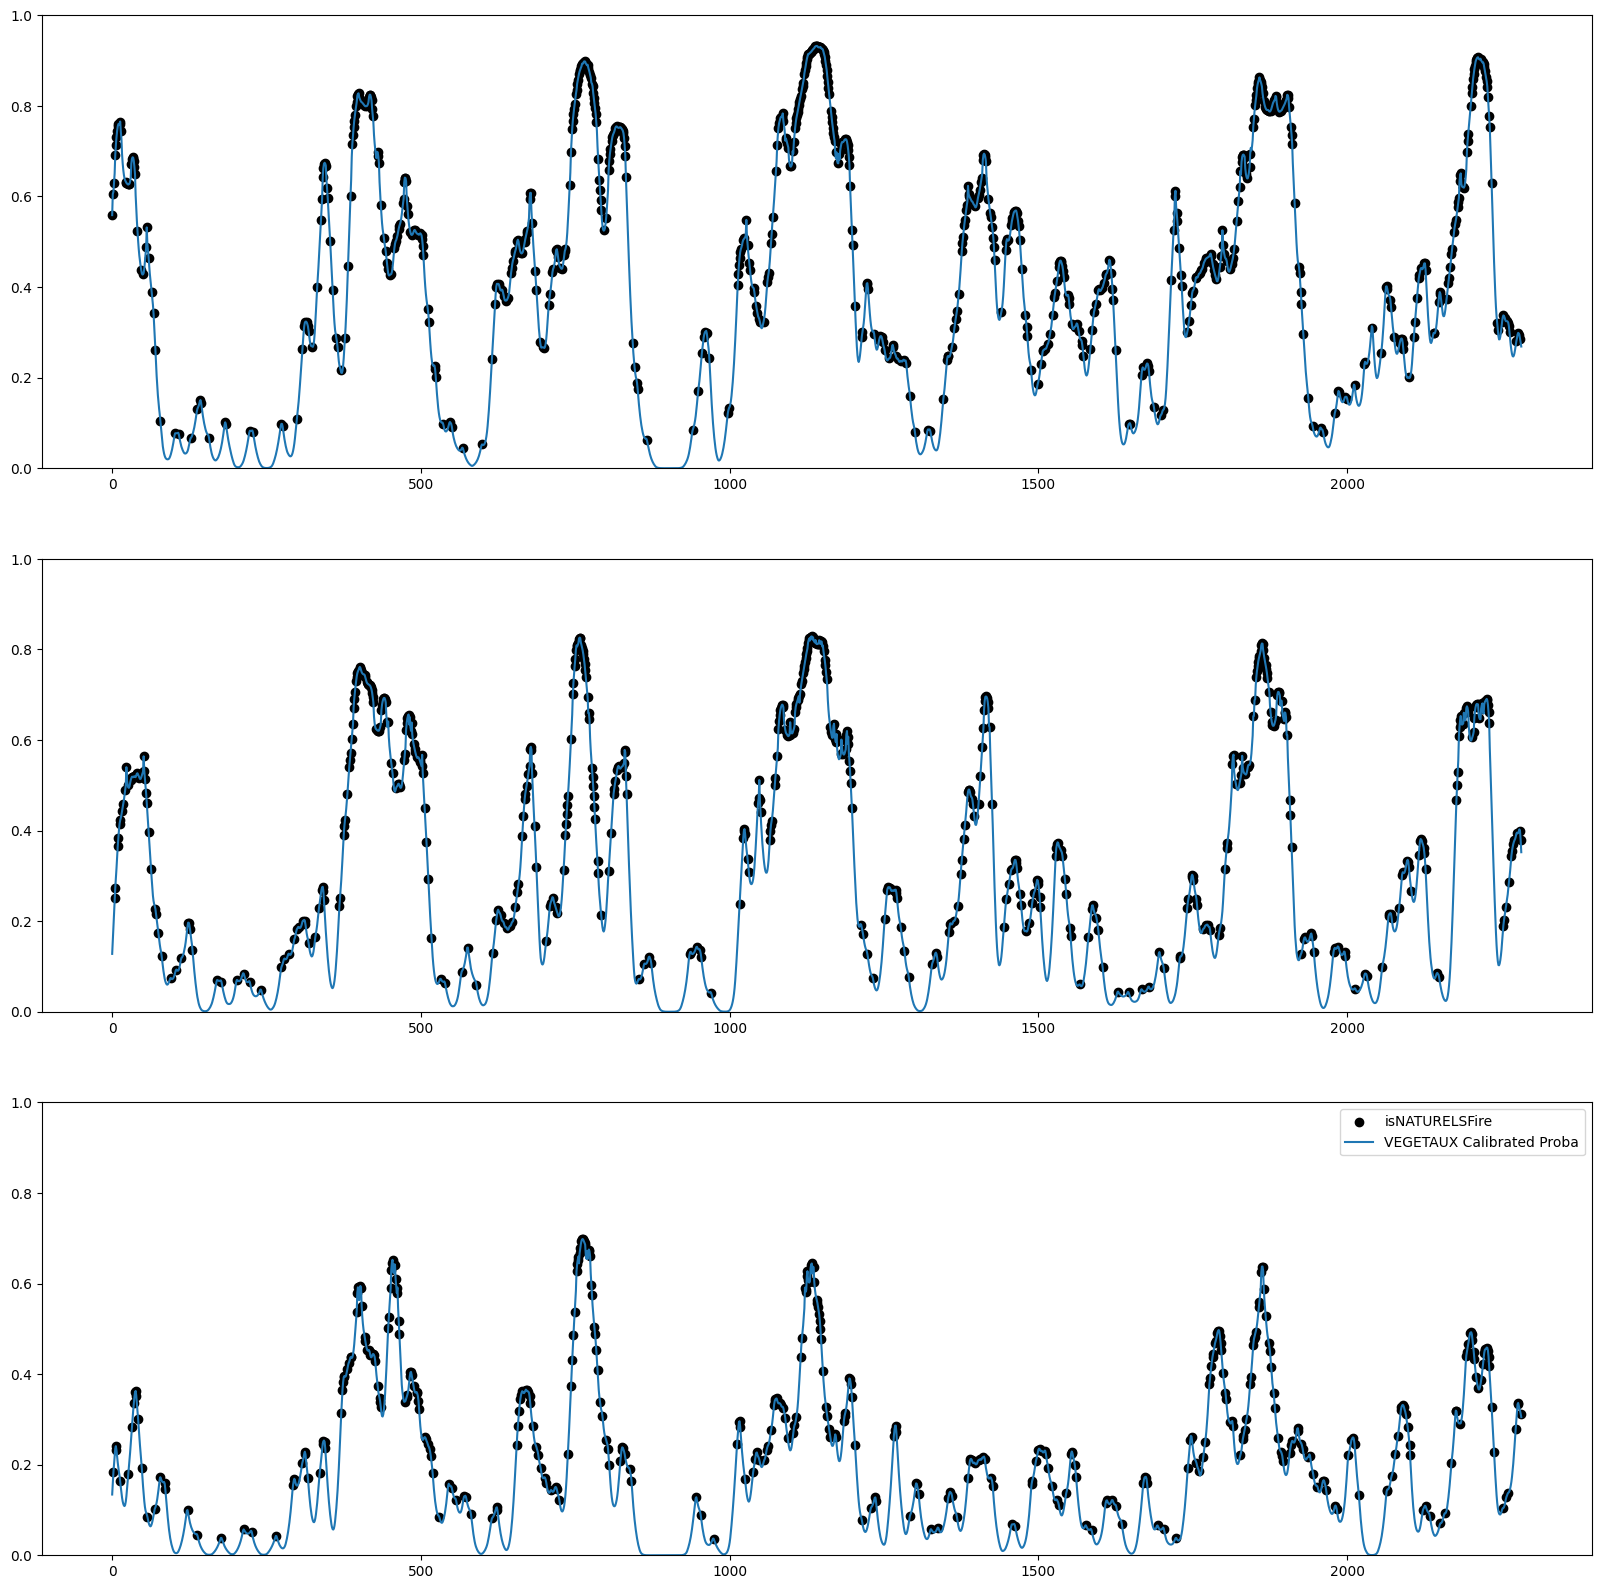

In [ ]:
dataset252 = dataset[(dataset['cluster'].isin(Yvelines))]
#print(dataset252[dataset252['creneau'] >= '2017-06-12']['nbFire'].sum())
clusterId = dataset252['cluster'].unique()

if len(clusterId) > 1:

    fig, ax = plt.subplots(len(clusterId), figsize = (20,20))

    for i, cID in enumerate(clusterId):
        dataset252_ = dataset252[(dataset252['cluster'] == cID)].reset_index(drop=True)
        #dataset252_Fire = dataset252_[dataset252_['isAGRICOLEFire'] > 0]
        #ax[i].scatter(dataset252_Fire.index.values, dataset252_Fire.calibratedProbaAGRICOLEFiretest, label='isAGRICOLEFire', color='black')
        dataset252_Fire = dataset252_[dataset252_['is'+sinister] > 0]
        ax[i].scatter(dataset252_Fire.index.values, dataset252_Fire['calibratedProba'+sinister+'test'], label='isNATURELSFire', color='black')
        #ax[i].plot(dataset252_.index.values, dataset252_.influenceNATURELSFirebefore.values, label='influence')
        ax[i].plot(dataset252_.index.values, dataset252_['calibratedProba'+sinister+'test'].values, label='VEGETAUX Calibrated Proba')
        #ax[i].plot(dataset252_.index.values, dataset252_.calibratedProbaFORETFiretest.values, label='FORET Calibrated Proba')
        #ax[i].plot(dataset252_.index.values, dataset252_.calibratedProbaAGRICOLEFiretest.values, label='AGRICOLE Calibrated Proba')
        #ax[i].plot(dataset252_.index.values, dataset252_.classCalibratedProba.values, label='Calibrated Proba')
        #ax[i].plot(dataset252_.index.values, dataset252_.fireInfluence.values, label='Fire Influence')
        ax[i].set_ylim([0, 1])
    plt.legend()
    plt.savefig(dir_csv/'yvelines.png')

else:
    fig, ax = plt.subplots(1, figsize = (20,5))

    dataset252_ = dataset[(dataset['departement'] == 78)].reset_index(drop=True)
    ax.plot(dataset252_.index.values, dataset252_.isFire.values, label='IsFire')
    ax.plot(dataset252_.index.values, dataset252_.calibratedProbaNATURELSFiretest.values, label='Calibrated Proba')
    ax.plot(dataset252_.index.values, dataset252_.calibratedProbaAGRICOLEFiretest.values, label='AGRICOLE Calibrated Proba')
    #ax[i].plot(dataset252_.index.values, dataset252_.classCalibratedProba.values, label='Calibrated Proba')
    #ax[i].plot(dataset252_.index.values, dataset252_.fireInfluence.values, label='Fire Influence')
    plt.legend()
    plt.savefig(dir_csv/'yvelines.png')

In [ ]:
print(dataset[dataset['departement'] == 1]['nbFire'].max())
print(dataset[dataset['departement'] == 25]['nbFire'].max())
print(dataset[dataset['departement'] == 69]['nbFire'].max())
print(dataset[dataset['departement'] == 78]['nbFire'].max())

KeyError: 'nbFire'

In [ ]:
plt.scatter(dataset['nbFire'], dataset['calibratedProba'])

KeyError: 'calibratedProba'

(array([5.5073e+04, 5.0750e+03, 7.0800e+02, 0.0000e+00, 1.1900e+02,
        3.3000e+01, 0.0000e+00, 7.0000e+00, 3.0000e+00, 2.0000e+00]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

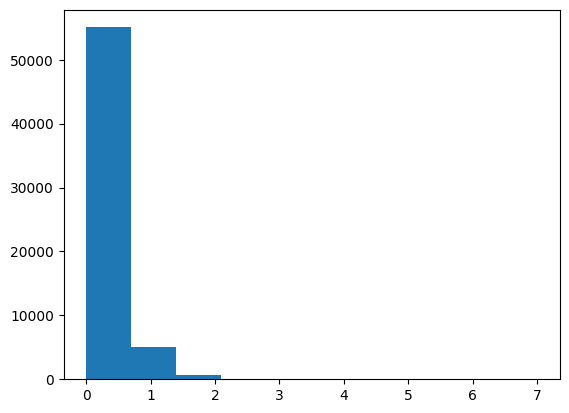

In [ ]:
plt.hist(dataset['nbFire'], bins=10)

In [ ]:
print(dataset[dataset['departement'] == 78]['nbFire'].max())
print(dataset[dataset['departement'] == 1]['nbFire'].max())
print(dataset[dataset['departement'] == 25]['nbFire'].max())

print(dataset[dataset['departement'] == 78]['nbFire'].mean())
print(dataset[dataset['departement'] == 1]['nbFire'].mean())
print(dataset[dataset['departement'] == 25]['nbFire'].mean())

print(dataset[dataset['departement'] == 78]['nbFire'].min())
print(dataset[dataset['departement'] == 1]['nbFire'].min())
print(dataset[dataset['departement'] == 25]['nbFire'].min())

6
7
nan
0.1222952255803767
0.14408653846153846
nan
0
0
nan


In [ ]:
print(dataset[dataset['nbFire'] == dataset['nbFire'].max()]['cluster'])

14732    4
52337    3
Name: cluster, dtype: int64


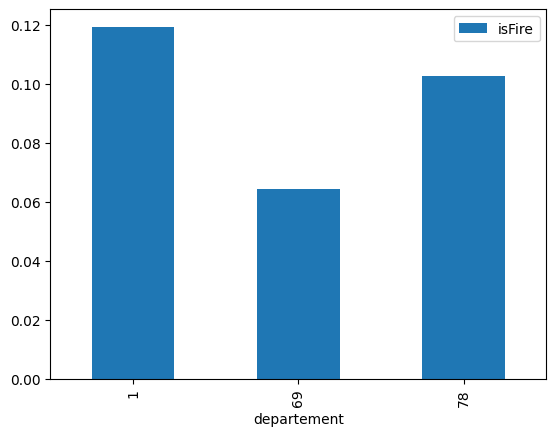

In [ ]:
dataset.groupby('departement')['isFire'].mean().plot.bar()
plt.legend()

<Axes: xlabel='departement'>

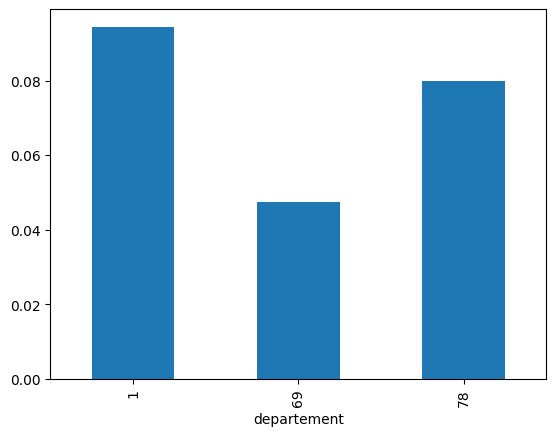

In [ ]:
dataset.groupby('departement')['fireInfluence'].mean().plot.bar()

<Axes: xlabel='departement'>

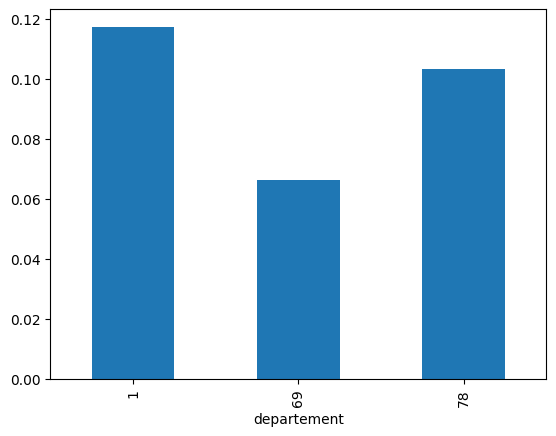

In [ ]:
dataset.groupby('departement')['calibratedProba'].mean().plot.bar()

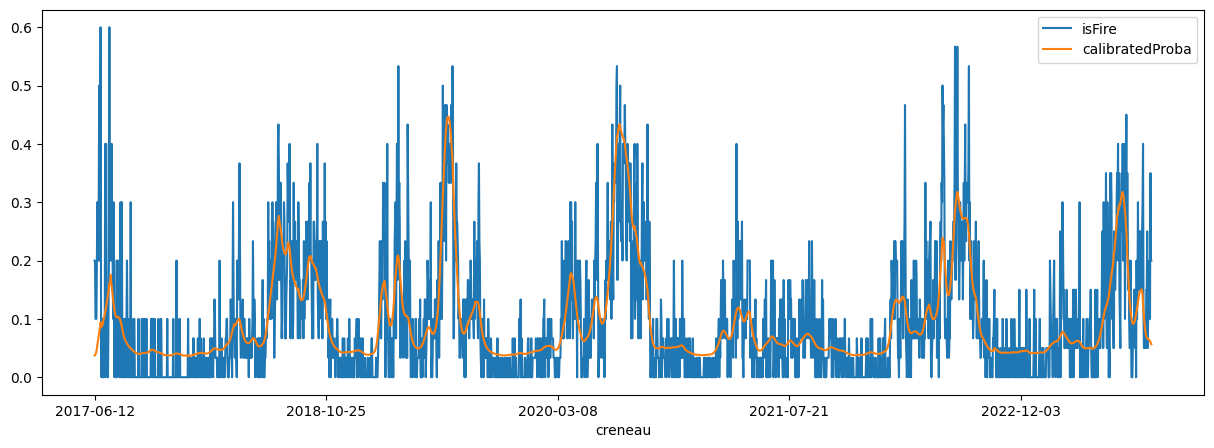

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,5))

dataset.groupby('creneau')['isFire'].mean().plot(ax=ax)
dataset.groupby('creneau')['calibratedProba'].mean().plot(ax=ax)
#dataset.groupby('creneau')['fireInfluence'].mean().plot(ax=ax)
plt.legend()

In [ ]:
dataset['class'] = dataset['classCalibrated']

KeyError: 'classCalibrated'

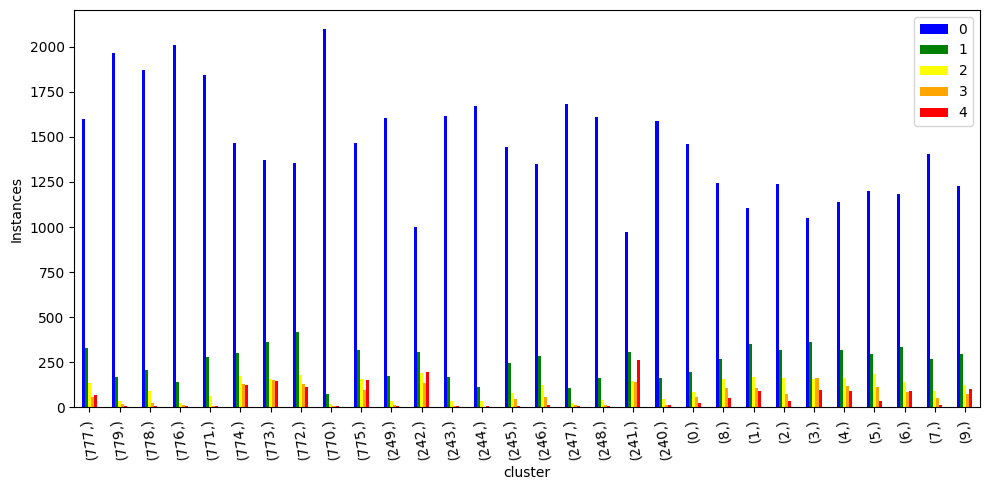

In [ ]:
hist = pd.DataFrame(index=pd.MultiIndex.from_product([dataset.cluster.unique(), ['0'], ['1'], ['2'], ['3'], ['4']],  names=['cluster', '0', '1', '2', '3', '4']))
hist.reset_index(inplace=True)
hist.dropna(inplace=True)

gpb = dataset.groupby(['cluster', 'class'])['coef'].sum()
for index, row in hist.iterrows():
    for c in ['0', '1', '2', '3', '4']:
        try:
            hist.loc[index, c] = gpb.loc[row['cluster'], int(c)]
        except:
            hist.loc[index, c] = 5
            
hist.index = pd.MultiIndex.from_arrays([hist.cluster])
hist.drop('cluster', axis=1, inplace=True)
fig, ax = plt.subplots(1, figsize = (10,5))
hist.plot.bar(rot=0, color={"0": "blue", "1": "green", "2": "yellow", "3": "orange", "4": "red"}, ax=ax)
ax.set_xlabel('cluster')
ax.tick_params(axis='x', labelrotation = 100)
ax.set_ylabel('Instances')
plt.tight_layout()
plt.show()

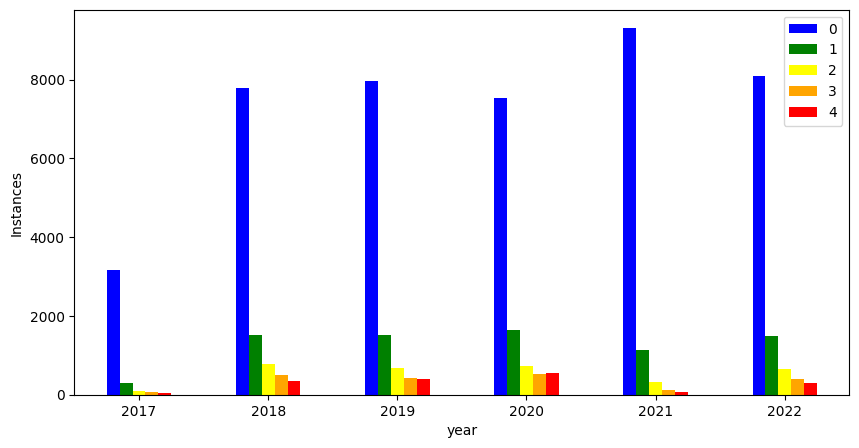

In [ ]:
dataset['year'] = dataset['creneau'].apply(lambda x : x.split('-')[0])

hist = pd.DataFrame(index=pd.MultiIndex.from_product([dataset.year.unique(), ['0'], ['1'], ['2'], ['3'], ['4']],  names=['year', '0', '1', '2', '3', '4']))
hist.reset_index(inplace=True)
hist.dropna(inplace=True)

gpb = dataset.groupby(['year', 'class'])['coef'].sum()
for index, row in hist.iterrows():
    for c in ['0', '1', '2', '3', '4']:
        try:
            hist.loc[index, c] = gpb.loc[row['year'], int(c)]
        except:
            hist.loc[index, c] = 5
            
hist.index = hist.year
hist.drop('year', axis=1, inplace=True)
fig, ax = plt.subplots(1, figsize = (10,5))
hist.plot.bar(rot=0, color={"0": "blue", "1": "green", "2": "yellow", "3": "orange", "4": "red"}, ax=ax)
ax.set_xlabel('year')
ax.set_ylabel('Instances')
plt.show()

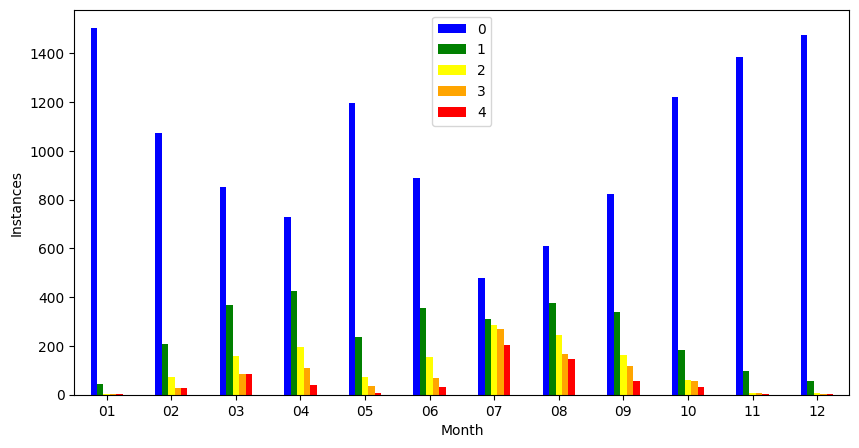

In [ ]:
dataset2020 = dataset[(dataset['departement'] == 1)] 

hist = pd.DataFrame(index=pd.MultiIndex.from_product([dataset2020.month.unique(), ['0'], ['1'], ['2'], ['3'], ['4']],  names=['month', '0', '1', '2', '3', '4']))
hist.reset_index(inplace=True)
hist.dropna(inplace=True)

gpb = dataset2020.groupby(['month', 'class'])['coef'].sum()
for index, row in hist.iterrows():
    for c in ['0', '1', '2', '3', '4']:
        try:
            hist.loc[index, c] = gpb.loc[row['month'], int(c)]
        except:
            hist.loc[index, c] = 5
            
hist.index = hist.month
hist.drop('month', axis=1, inplace=True)
fig, ax = plt.subplots(1, figsize = (10,5))
hist.plot.bar(rot=0, color={"0": "blue", "1": "green", "2": "yellow", "3": "orange", "4": "red"}, ax=ax)
ax.set_xlabel('Month')
ax.set_ylabel('Instances')
plt.show()

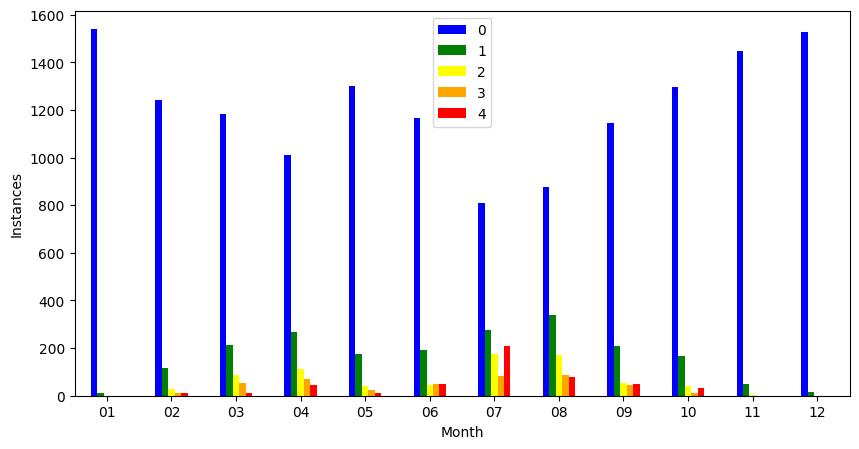

In [ ]:
dataset2020 = dataset[(dataset['departement'] == 25)] 

hist = pd.DataFrame(index=pd.MultiIndex.from_product([dataset2020.month.unique(), ['0'], ['1'], ['2'], ['3'], ['4']],  names=['month', '0', '1', '2', '3', '4']))
hist.reset_index(inplace=True)
hist.dropna(inplace=True)

gpb = dataset2020.groupby(['month', 'class'])['coef'].sum()
for index, row in hist.iterrows():
    for c in ['0', '1', '2', '3', '4']:
        try:
            hist.loc[index, c] = gpb.loc[row['month'], int(c)]
        except:
            hist.loc[index, c] = 0
            
hist.index = hist.month
hist.drop('month', axis=1, inplace=True)
fig, ax = plt.subplots(1, figsize = (10,5))
hist.plot.bar(rot=0, color={"0": "blue", "1": "green", "2": "yellow", "3": "orange", "4": "red"}, ax=ax)
ax.set_xlabel('Month')
ax.set_ylabel('Instances')
plt.show()

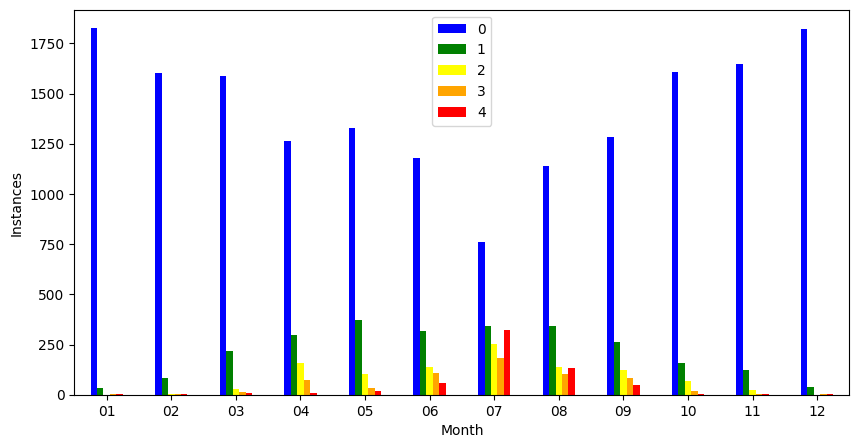

In [ ]:
dataset2020 = dataset[(dataset['departement'] == 78)] 

hist = pd.DataFrame(index=pd.MultiIndex.from_product([dataset2020.month.unique(), ['0'], ['1'], ['2'], ['3'], ['4']],  names=['month', '0', '1', '2', '3', '4']))
hist.reset_index(inplace=True)
hist.dropna(inplace=True)

gpb = dataset2020.groupby(['month', 'class'])['coef'].sum()
for index, row in hist.iterrows():
    for c in ['0', '1', '2', '3', '4']:
        try:
            hist.loc[index, c] = gpb.loc[row['month'], int(c)]
        except:
            hist.loc[index, c] = 5
            
hist.index = hist.month
hist.drop('month', axis=1, inplace=True)
fig, ax = plt.subplots(1, figsize = (10,5))
hist.plot.bar(rot=0, color={"0": "blue", "1": "green", "2": "yellow", "3": "orange", "4": "red"}, ax=ax)
ax.set_xlabel('Month')
ax.set_ylabel('Instances')
plt.show()

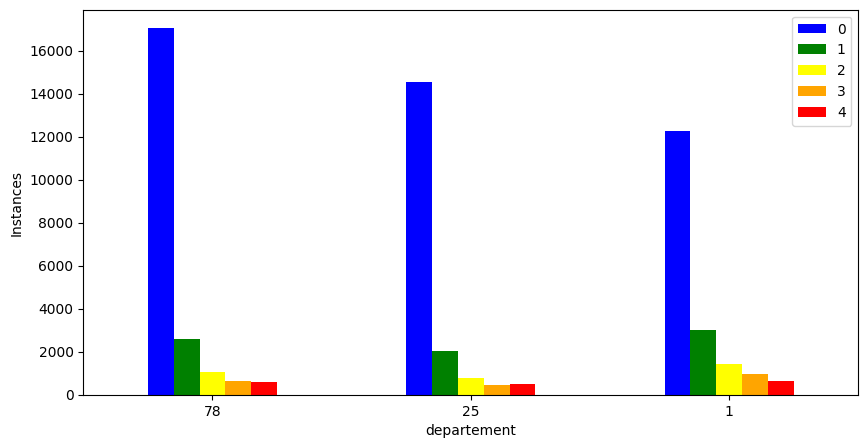

In [ ]:
hist = pd.DataFrame(index=pd.MultiIndex.from_product([dataset.departement.unique(), ['0'], ['1'], ['2'], ['3'], ['4']],  names=['departement', '0', '1', '2', '3', '4']))
hist.reset_index(inplace=True)
hist.dropna(inplace=True)

gpb = dataset.groupby(['departement', 'class'])['coef'].sum()
for index, row in hist.iterrows():
    for c in ['0', '1', '2', '3', '4']:
        try:
            hist.loc[index, c] = gpb.loc[row['departement'], int(c)]
        except:
            hist.loc[index, c] = 0
            
hist.index = hist.departement
hist.drop('departement', axis=1, inplace=True)
fig, ax = plt.subplots(1, figsize = (10,5))
hist.plot.bar(rot=0, color={"0": "blue", "1": "green", "2": "yellow", "3": "orange", "4": "red"}, ax=ax)
ax.set_xlabel('departement')
ax.set_ylabel('Instances')
plt.show()

In [ ]:
"""for var in variables:
    temp = dataset.copy(deep=True).dropna(subset=var)
    if len(temp) != len(dataset):
        print(var)"""

'for var in variables:\n    temp = dataset.copy(deep=True).dropna(subset=var)\n    if len(temp) != len(dataset):\n        print(var)'

In [ ]:
dataset[dataset['departement'] == 78].year.unique()

array(['2017', '2018', '2019', '2020', '2021', '2022'], dtype=object)

In [ ]:
ded

### PROCESS

In [ ]:
print(len(dataset))

58410


In [ ]:
#dataset.drop(dataset[dataset['dc_0'] < 0].index, inplace=True)
#dataset.drop(dataset[dataset['dmc_0'] < 0].index, inplace=True)

dataset['dc_0'] = dataset['dc_0'].apply(lambda x : 0 if x < 0 else x)
dataset['dc_min'] =  dataset['dc_0'].apply(lambda x : 0 if x < 0 else x)
dataset['dc_mean'] =  dataset['dc_0'].apply(lambda x : 0 if x < 0 else x)
dataset['dc_max'] = dataset['dc_0'].apply(lambda x : 0 if x < 0 else x)

dataset['dmc_0'] = dataset['dc_0'].apply(lambda x : 0 if x < 0 else x)
dataset['dmc_min'] =  dataset['dc_0'].apply(lambda x : 0 if x < 0 else x)
dataset['dmc_mean'] =  dataset['dc_0'].apply(lambda x : 0 if x < 0 else x)
dataset['dmc_max'] = dataset['dc_0'].apply(lambda x : 0 if x < 0 else x)

In [ ]:
loglossProba = np.zeros(shape=(len(dataset), 2))
loglossProba[:,0] = 1 - dataset['calibratedProba'].values
loglossProba[:,1] = dataset['calibratedProba'].values

print(log_loss(dataset['isFire'].values, loglossProba, sample_weight=dataset['weights']))

loglossProba = np.zeros(shape=(len(dataset[dataset['isFire'] == 1]), 2))
loglossProba[:,0] = 1 - dataset[dataset['isFire'] == 1]['calibratedProba'].values
loglossProba[:,1] = dataset[dataset['isFire'] == 1]['calibratedProba'].values

print(log_loss(dataset[dataset['isFire'] == 1]['isFire'].values, loglossProba, sample_weight=dataset[dataset['isFire'] == 1]['weights'], labels=[0,1]))

0.6901624269992267
1.2907659201002806


In [ ]:
dataset.dropna(subset=variables, inplace=True)
print(len(dataset))

57500


In [ ]:
loglossProba = np.zeros(shape=(len(dataset), 2))
loglossProba[:,0] = 1 - dataset['calibratedProba'].values
loglossProba[:,1] = dataset['calibratedProba'].values

print(log_loss(dataset['isFire'].values, loglossProba, sample_weight=dataset['weights']))

loglossProba = np.zeros(shape=(len(dataset[dataset['isFire'] == 1]), 2))
loglossProba[:,0] = 1 - dataset[dataset['isFire'] == 1]['calibratedProba'].values
loglossProba[:,1] = dataset[dataset['isFire'] == 1]['calibratedProba'].values

print(log_loss(dataset[dataset['isFire'] == 1]['isFire'].values, loglossProba, sample_weight=dataset[dataset['isFire'] == 1]['weights'], labels=[0,1]))

0.6928733791358557
1.2869018344433014


In [ ]:
print(len(dataset[dataset['departement'] == 78]), len(dataset[(dataset['departement'] == 78) & (dataset['year'] > '2017')]))
print(len(dataset[dataset['departement'] == 1]))
print(len(dataset[dataset['departement'] == 25]))

21600 17950
17950
17950


In [ ]:
print(dataset[dataset['departement'] == 78]['nbFire'].sum(), dataset[(dataset['departement'] == 78) & (dataset['year'] > '2017')]['nbFire'].sum())
print(dataset[dataset['departement'] == 1]['nbFire'].sum())
print(dataset[dataset['departement'] == 25]['nbFire'].sum())

2543 2274
2879
1896


In [ ]:
print(dataset[(dataset['departement'] == 78) & (dataset['isFire'] == 1)]['calibratedProba'].mean())
print(dataset[(dataset['departement'] == 1) & (dataset['isFire'] == 1)]['calibratedProba'].mean())
print(dataset[(dataset['departement'] == 25) & (dataset['isFire'] == 1)]['calibratedProba'].mean())

0.3874885228159933
0.4087626303701996


0.3847189170738456


In [ ]:
print(dataset[(dataset['departement'] == 78) & (dataset['isFire'] == 1)]['calibratedProba'].min())
print(dataset[(dataset['departement'] == 1) & (dataset['isFire'] == 1)]['calibratedProba'].min())
print(dataset[(dataset['departement'] == 25) & (dataset['isFire'] == 1)]['calibratedProba'].min())

0.0324361673936841
0.0294167442825686
0.0268297901582464


In [ ]:
loglossProba = np.zeros(shape=(len(dataset), 2))
loglossProba[:,0] = 1 - dataset['calibratedProba'].values
loglossProba[:,1] = dataset['calibratedProba'].values

print(log_loss(dataset['isFire'].values, loglossProba, sample_weight=dataset['weights']))

loglossProba = np.zeros(shape=(len(dataset[dataset['isFire'] == 1]), 2))
loglossProba[:,0] = 1 - dataset[dataset['isFire'] == 1]['calibratedProba'].values
loglossProba[:,1] = dataset[dataset['isFire'] == 1]['calibratedProba'].values

print(log_loss(dataset[dataset['isFire'] == 1]['isFire'].values, loglossProba, sample_weight=dataset[dataset['isFire'] == 1]['weights'], labels=[0,1]))

0.6928733791358557
1.2869018344433014


### Under sampling

In [ ]:
dataset2 = dataset.copy(deep=True)

In [ ]:
"""dataset = dataset2.copy(deep=True)

classToSample = [0, 1, 2, 3, 4]

for dep in dataset.departement.unique():
    depDataset = dataset[dataset['departement'] == dep]
    for c in depDataset.cluster.unique():
        clusterDataset = depDataset[depDataset['cluster'] == c]
        gpb = clusterDataset.groupby(['class'])['coef'].sum()
        #print(gpb)
        gpb = gpb.reset_index()
        maxNo0 = np.min(gpb['coef'].values)
        cMin = gpb[gpb['coef'] == maxNo0]['class'].values[0]
        print(cMin, maxNo0, c, dep)
        #print(maxNo0)
        for cs in classToSample:
            if cs == cMin:
                continue
            dataset.drop(clusterDataset[clusterDataset['class'] == cs].sample(len(clusterDataset[clusterDataset['class'] == cs]) - maxNo0).index, inplace=True)"""

"dataset = dataset2.copy(deep=True)\n\nclassToSample = [0, 1, 2, 3, 4]\n\nfor dep in dataset.departement.unique():\n    depDataset = dataset[dataset['departement'] == dep]\n    for c in depDataset.cluster.unique():\n        clusterDataset = depDataset[depDataset['cluster'] == c]\n        gpb = clusterDataset.groupby(['class'])['coef'].sum()\n        #print(gpb)\n        gpb = gpb.reset_index()\n        maxNo0 = np.min(gpb['coef'].values)\n        cMin = gpb[gpb['coef'] == maxNo0]['class'].values[0]\n        print(cMin, maxNo0, c, dep)\n        #print(maxNo0)\n        for cs in classToSample:\n            if cs == cMin:\n                continue\n            dataset.drop(clusterDataset[clusterDataset['class'] == cs].sample(len(clusterDataset[clusterDataset['class'] == cs]) - maxNo0).index, inplace=True)"

In [ ]:
gbp = dataset.groupby(['classCalibrated'])['coef'].sum()
maxValue = np.max(gbp.loc[:])
gbp = gbp.reset_index()
gbp

,classCalibrated,coef
0,0,42945
1,1,7607
2,2,3221
3,3,2009
4,4,1718


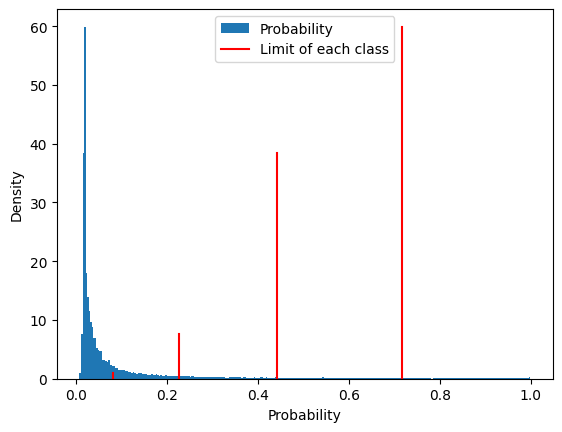

In [ ]:
hist = plt.hist(dataset['calibratedProba'], bins='auto', density=True, label='Probability')
hist = hist[0]
plt.plot([dataset['classCalibratedProba'].unique()[0] + (dataset['classCalibratedProba'].unique()[1] - dataset['classCalibratedProba'].unique()[0]) / 2 for i in np.linspace(0, np.resize(hist, 5)[0])], [i for i in np.linspace(0, np.resize(hist, 5)[0])], color='red', label='Limit of each class')
plt.plot([dataset['classCalibratedProba'].unique()[1] + (dataset['classCalibratedProba'].unique()[2] - dataset['classCalibratedProba'].unique()[1]) / 2 for i in np.linspace(0, np.resize(hist, 5)[1])], [i for i in np.linspace(0, np.resize(hist, 5)[1])], color='red')
plt.plot([dataset['classCalibratedProba'].unique()[2] + (dataset['classCalibratedProba'].unique()[3] - dataset['classCalibratedProba'].unique()[2]) / 2 for i in np.linspace(0, np.resize(hist, 5)[2])], [i for i in np.linspace(0, np.resize(hist, 5)[2])], color='red')
plt.plot([dataset['classCalibratedProba'].unique()[3] + (dataset['classCalibratedProba'].unique()[4] - dataset['classCalibratedProba'].unique()[3]) / 2 for i in np.linspace(0, np.resize(hist, 5)[3])], [i for i in np.linspace(0, np.resize(hist, 5)[3])], color='red')
#plt.plot([dataset_under_sample['classCalibratedProba'].unique()[4] for i in np.linspace(0, np.resize(hist, 5)[4])], [i for i in np.linspace(0, np.resize(hist, 5)[4])], color='R', label='Class Center')
plt.ylabel('Density')
plt.xlabel('Probability')
plt.legend()

In [ ]:
len(dataset[dataset['isFire'] == 1])

5956

In [ ]:
"""dataset = dataset2.copy(deep=True)

dataset_under_sample = []

numjour = 30

for cluster in dataset.cluster.unique():
    dataCluster = dataset[dataset['cluster'] == cluster].reset_index(drop=True)
    indexFire = dataCluster[dataCluster['isFire'] == 1].index
    for ind in indexFire:
        if ind - numjour > 0 and ind + numjour < dataCluster.index[-1]:
            dataset_under_sample.append(dataCluster.loc[(ind - numjour): ind+numjour])
    
dataset_under_sample = pd.concat(dataset_under_sample)
dataset_under_sample.drop_duplicates(inplace=True)
dataset = dataset_under_sample.copy(deep=True).reset_index(drop=True)"""

"dataset = dataset2.copy(deep=True)\n\ndataset_under_sample = []\n\nnumjour = 30\n\nfor cluster in dataset.cluster.unique():\n    dataCluster = dataset[dataset['cluster'] == cluster].reset_index(drop=True)\n    indexFire = dataCluster[dataCluster['isFire'] == 1].index\n    for ind in indexFire:\n        if ind - numjour > 0 and ind + numjour < dataCluster.index[-1]:\n            dataset_under_sample.append(dataCluster.loc[(ind - numjour): ind+numjour])\n    \ndataset_under_sample = pd.concat(dataset_under_sample)\ndataset_under_sample.drop_duplicates(inplace=True)\ndataset = dataset_under_sample.copy(deep=True).reset_index(drop=True)"

In [ ]:
gbp = dataset.groupby(['classCalibrated'])['coef'].sum()
maxValue = np.max(gbp.loc[:])
gbp = gbp.reset_index()
gbp

,classCalibrated,coef
0,0,42945
1,1,7607
2,2,3221
3,3,2009
4,4,1718


In [ ]:
"""val = 2500

for c in dataset.classCalibrated.unique():
    leni = len(dataset[(dataset['classCalibrated'] == c) & (dataset['isFire'] != 1)])
    print(leni)
    if leni < val:
        continue
    dataset.drop(dataset[(dataset['classCalibrated'] == c) & (dataset['isFire'] != 1)].sample(leni - val).index, inplace=True)

gbp = dataset.groupby(['classCalibrated'])['coef'].sum()
maxValue = np.max(gbp.loc[:])
gbp = gbp.reset_index()
gbp"""

"val = 2500\n\nfor c in dataset.classCalibrated.unique():\n    leni = len(dataset[(dataset['classCalibrated'] == c) & (dataset['isFire'] != 1)])\n    print(leni)\n    if leni < val:\n        continue\n    dataset.drop(dataset[(dataset['classCalibrated'] == c) & (dataset['isFire'] != 1)].sample(leni - val).index, inplace=True)\n\ngbp = dataset.groupby(['classCalibrated'])['coef'].sum()\nmaxValue = np.max(gbp.loc[:])\ngbp = gbp.reset_index()\ngbp"

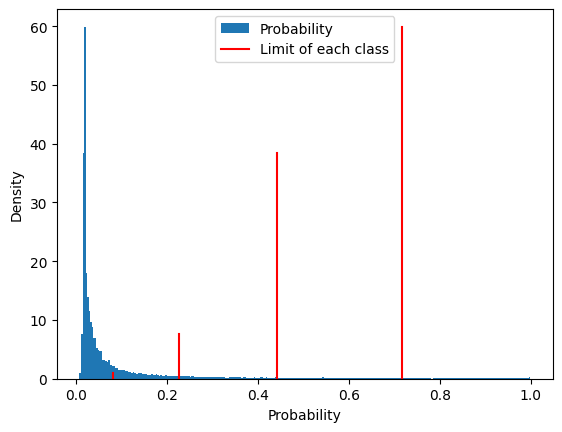

In [ ]:
hist = plt.hist(dataset['calibratedProba'], bins='auto', density=True, label='Probability')
hist = hist[0]
plt.plot([dataset['classCalibratedProba'].unique()[0] + (dataset['classCalibratedProba'].unique()[1] - dataset['classCalibratedProba'].unique()[0]) / 2 for i in np.linspace(0, np.resize(hist, 5)[0])], [i for i in np.linspace(0, np.resize(hist, 5)[0])], color='red', label='Limit of each class')
plt.plot([dataset['classCalibratedProba'].unique()[1] + (dataset['classCalibratedProba'].unique()[2] - dataset['classCalibratedProba'].unique()[1]) / 2 for i in np.linspace(0, np.resize(hist, 5)[1])], [i for i in np.linspace(0, np.resize(hist, 5)[1])], color='red')
plt.plot([dataset['classCalibratedProba'].unique()[2] + (dataset['classCalibratedProba'].unique()[3] - dataset['classCalibratedProba'].unique()[2]) / 2 for i in np.linspace(0, np.resize(hist, 5)[2])], [i for i in np.linspace(0, np.resize(hist, 5)[2])], color='red')
plt.plot([dataset['classCalibratedProba'].unique()[3] + (dataset['classCalibratedProba'].unique()[4] - dataset['classCalibratedProba'].unique()[3]) / 2 for i in np.linspace(0, np.resize(hist, 5)[3])], [i for i in np.linspace(0, np.resize(hist, 5)[3])], color='red')
#plt.plot([dataset_under_sample['classCalibratedProba'].unique()[4] for i in np.linspace(0, np.resize(hist, 5)[4])], [i for i in np.linspace(0, np.resize(hist, 5)[4])], color='R', label='Class Center')

plt.ylabel('Density')
plt.xlabel('Probability')
plt.legend()

In [ ]:
gbp = dataset.groupby(['classCalibrated'])['coef'].sum()
maxValue = np.max(gbp.loc[:])
gbp = gbp.reset_index()
gbp

,classCalibrated,coef
0,0,42945
1,1,7607
2,2,3221
3,3,2009
4,4,1718


In [ ]:
dataset['calibratedProba'].quantile([0.05, 0.5, 0.95])

0.05    0.015463
0.50    0.030770
0.95    0.539766
Name: calibratedProba, dtype: float64

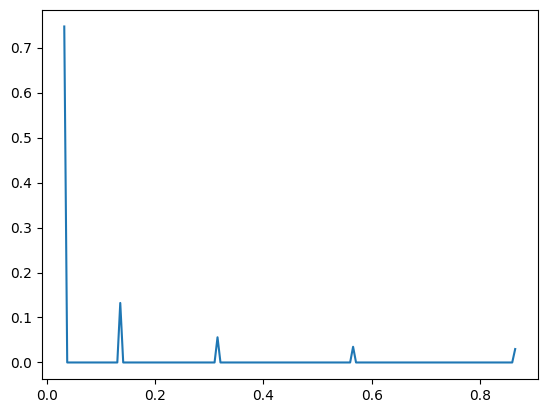

In [ ]:
hist_, bin_edges_ = np.histogram(dataset['classCalibratedProba'], bins='auto')
bin_edges_ = (bin_edges_ + np.roll(bin_edges_, -1))[:-1] / 2.0
hist_=hist_/np.sum(hist_)
plt.plot(bin_edges_, hist_)

In [ ]:
gbp = dataset.groupby(['classCalibrated'])['coef'].sum()
maxValue = np.max(gbp.loc[:])
gbp = gbp.reset_index()
gbp

,classCalibrated,coef
0,0,42945
1,1,7607
2,2,3221
3,3,2009
4,4,1718


In [ ]:
"""val = 2500

for c in dataset.classCalibrated.unique():
    leni = len(dataset[(dataset['classCalibrated'] == c) & (dataset['isFire'] != 1)])
    print(leni)
    if leni < val:
        continue
    dataset.drop(dataset[(dataset['classCalibrated'] == c) & (dataset['isFire'] != 1)].sample(leni - val).index, inplace=True)

gbp = dataset.groupby(['classCalibrated'])['coef'].sum()
maxValue = np.max(gbp.loc[:])
gbp = gbp.reset_index()
gbp"""

"val = 2500\n\nfor c in dataset.classCalibrated.unique():\n    leni = len(dataset[(dataset['classCalibrated'] == c) & (dataset['isFire'] != 1)])\n    print(leni)\n    if leni < val:\n        continue\n    dataset.drop(dataset[(dataset['classCalibrated'] == c) & (dataset['isFire'] != 1)].sample(leni - val).index, inplace=True)\n\ngbp = dataset.groupby(['classCalibrated'])['coef'].sum()\nmaxValue = np.max(gbp.loc[:])\ngbp = gbp.reset_index()\ngbp"

In [ ]:
gbp = dataset.groupby(['isFire', 'departement'])['coef'].sum()
maxValue = np.max(gbp.loc[:])
gbp = gbp.reset_index()
gbp

,isFire,departement,coef
0,0,1,15607
1,0,25,16413
2,0,78,19524
3,1,1,2343
4,1,25,1537
5,1,78,2076


### Train val test

In [ ]:
import datetime as dt
from sklearn.model_selection import train_test_split

def find_dates(start, end):
    start_date = dt.datetime.strptime(start, '%Y-%m-%d').date()
    end_date = dt.datetime.strptime(end, '%Y-%m-%d').date()

    delta = dt.timedelta(days=1)
    date = start_date
    res = []
    while date < end_date:
            res.append(date.strftime("%Y-%m-%d"))
            date += delta
    return res


def train_val_test_split(dataset, testsize, valsize, offset, seq_len):
    clustersID = dataset.cluster.unique()
    
    train = []
    test = []
    val = []

    randomChoice = [1,2,3]
    randomWeight = [1 - testsize - valsize, valsize, testsize]

    for j, cluster in enumerate(clustersID):
        i = 0
        print(cluster)
        data = dataset[dataset['cluster'] == cluster].reset_index(drop=True)
        indexMax = data.index[-1]
        while i < indexMax:
            choice = random.choices(randomChoice, randomWeight)[0]

            if choice == 1:
                train.append(data[i:i+seq_len])
            elif choice == 2:
                val.append(data[i:i+seq_len])
            else:
                test.append(data[i:i+seq_len])
            
            i += seq_len + offset

    return pd.concat(train).sort_values('creneau').reset_index(drop=True), pd.concat(val).sort_values('creneau').reset_index(drop=True), pd.concat(test).sort_values('creneau').reset_index(drop=True)

In [ ]:
clustersID = dataset.cluster.unique()
offset = 0
seq_len = 10
train, val, test = train_val_test_split(dataset, 0.20, 0.20, offset, seq_len)

777
779
778
776
771
774
773
772
770
775
245
246
247
248
3
244
2
1
0
249
243
241
242
9
8
7
240
5
4
6


In [ ]:
loglossProba = np.zeros(shape=(len(dataset), 2))
loglossProba[:,0] = 1 - dataset['calibratedProba'].values
loglossProba[:,1] = dataset['calibratedProba'].values

print(log_loss(dataset['isFire'].values, loglossProba, sample_weight=dataset['weights']))

loglossProba = np.zeros(shape=(len(dataset[dataset['isFire'] == 1]), 2))
loglossProba[:,0] = 1 - dataset[dataset['isFire'] == 1]['calibratedProba'].values
loglossProba[:,1] = dataset[dataset['isFire'] == 1]['calibratedProba'].values

print(log_loss(dataset[dataset['isFire'] == 1]['isFire'].values, loglossProba, sample_weight=dataset[dataset['isFire'] == 1]['weights'], labels=[0,1]))

0.6928733791358557
1.2869018344433014


In [ ]:
loglossProba = np.zeros(shape=(len(train), 2))
loglossProba[:,0] = 1 - train['calibratedProba'].values
loglossProba[:,1] = train['calibratedProba'].values

print(log_loss(train['isFire'].values, loglossProba, sample_weight=train['weights']))

loglossProba = np.zeros(shape=(len(train[train['isFire'] == 1]), 2))
loglossProba[:,0] = 1 - train[train['isFire'] == 1]['calibratedProba'].values
loglossProba[:,1] = train[train['isFire'] == 1]['calibratedProba'].values

print(log_loss(train[train['isFire'] == 1]['isFire'].values, loglossProba, sample_weight=train[train['isFire'] == 1]['weights'], labels=[0,1]))

0.6931477636802139


1.3026668372427992


In [ ]:
loglossProba = np.zeros(shape=(len(val), 2))
loglossProba[:,0] = 1 - val['calibratedProba'].values
loglossProba[:,1] = val['calibratedProba'].values

print(log_loss(val['isFire'].values, loglossProba, sample_weight=val['weights']))

loglossProba = np.zeros(shape=(len(val[val['isFire'] == 1]), 2))
loglossProba[:,0] = 1 - val[val['isFire'] == 1]['calibratedProba'].values
loglossProba[:,1] = val[val['isFire'] == 1]['calibratedProba'].values

print(log_loss(val[val['isFire'] == 1]['isFire'].values, loglossProba, sample_weight=val[val['isFire'] == 1]['weights'], labels=[0,1]))

0.7026296061858271
1.2864050722554339


In [ ]:
loglossProba = np.zeros(shape=(len(test), 2))
loglossProba[:,0] = 1 - test['calibratedProba'].values
loglossProba[:,1] = test['calibratedProba'].values

print(log_loss(test['isFire'].values, loglossProba, sample_weight=test['weights']))

loglossProba = np.zeros(shape=(len(test[test['isFire'] == 1]), 2))
loglossProba[:,0] = 1 - test[test['isFire'] == 1]['calibratedProba'].values
loglossProba[:,1] = test[test['isFire'] == 1]['calibratedProba'].values

print(log_loss(test[test['isFire'] == 1]['isFire'].values, loglossProba, sample_weight=test[test['isFire'] == 1]['weights'], labels=[0,1]))

0.681481376061247


1.2415070905354835


In [ ]:
for i, cluster in enumerate(clustersID):
    print(cluster)
    if len(np.intersect1d(train[train['cluster'] == cluster].creneau.unique(), val[val['cluster'] == cluster].creneau.unique())) > 0:
        print('Train Val')
    
    if len(np.intersect1d(train[train['cluster'] == cluster].creneau.unique(), test[test['cluster'] == cluster].creneau.unique())) > 0:
        print('Train test')
   
    if len(np.intersect1d(test[test['cluster'] == cluster].creneau.unique(), val[val['cluster'] == cluster].creneau.unique())) > 0:
        print('Test Val')

777
779


778
776
771
774
773
772
770
775
245
246
247
248
3
244
2
1
0
249
243
241
242
9
8
7
240
5
4
6


In [ ]:
from sklearn.preprocessing import normalize, RobustScaler

"""trainval, test = train_test_split(dataset, test_size=0.20, random_state=42)
train, val = train_test_split(trainval, train_size=0.80, random_state=42)"""

train.sort_values('creneau', inplace=True)
test.sort_values('creneau', inplace=True)
val.sort_values('creneau', inplace=True)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
val = val.reset_index(drop=True)

print(len(train), len(test), len(val))

34225 11170 12105


In [ ]:
len(train) + len(test) + len(val)

57500

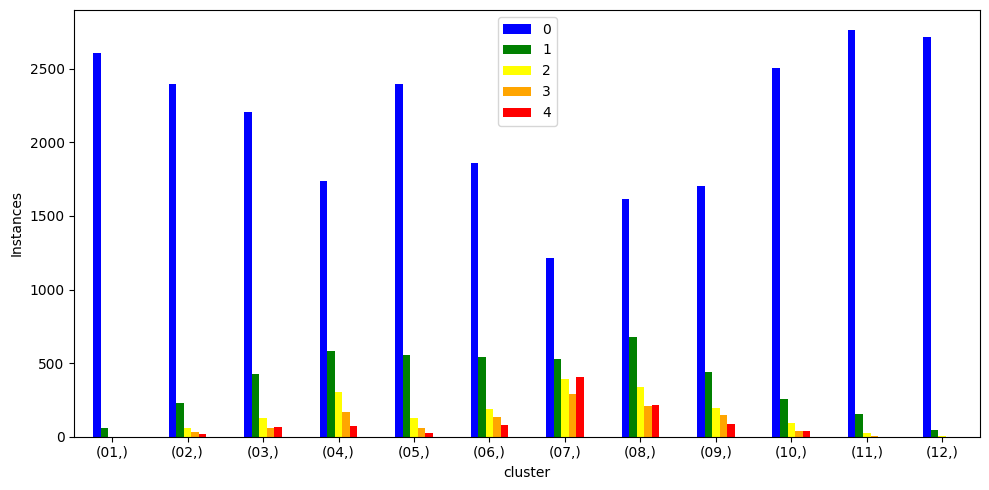

In [ ]:
hist = pd.DataFrame(index=pd.MultiIndex.from_product([train.month.unique(), ['0'], ['1'], ['2'], ['3'], ['4']],  names=['month', '0', '1', '2', '3', '4']))
hist.reset_index(inplace=True)
hist.dropna(inplace=True)

gpb = train.groupby(['month', 'class'])['coef'].sum()
for index, row in hist.iterrows():
    for c in ['0', '1', '2', '3', '4']:
        try:
            hist.loc[index, c] = gpb.loc[row['month'], int(c)]
        except:
            hist.loc[index, c] = 0
            
hist.index = pd.MultiIndex.from_arrays([hist.month])
hist.drop('month', axis=1, inplace=True)
fig, ax = plt.subplots(1, figsize = (10,5))
hist.plot.bar(rot=0, color={"0": "blue", "1": "green", "2": "yellow", "3": "orange", "4": "red"}, ax=ax)
ax.set_xlabel('cluster')
ax.set_ylabel('Instances')
plt.tight_layout()
plt.show()

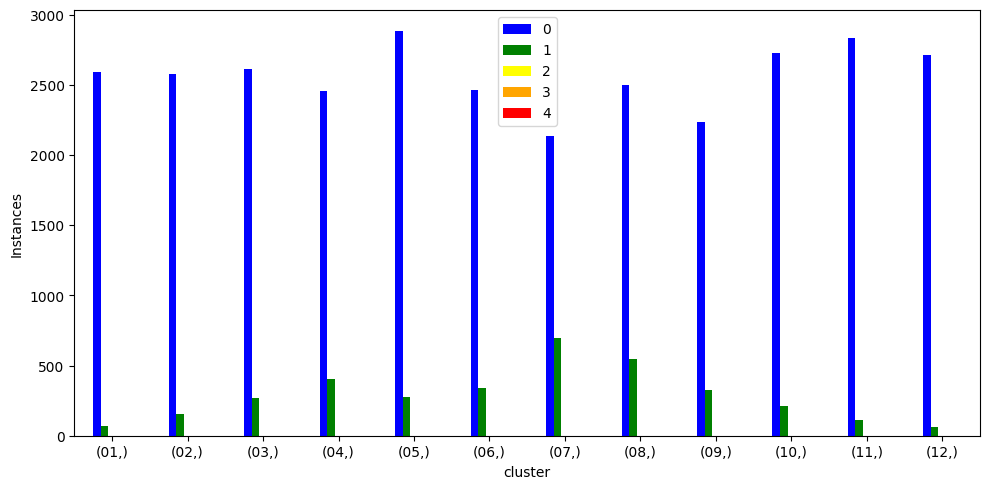

In [ ]:
hist = pd.DataFrame(index=pd.MultiIndex.from_product([train.month.unique(), ['0'], ['1']],  names=['month', '0', '1']))
hist.reset_index(inplace=True)
hist.dropna(inplace=True)

gpb = train.groupby(['month', 'isFire'])['coef'].sum()
for index, row in hist.iterrows():
    for c in ['0', '1', '2', '3', '4']:
        try:
            hist.loc[index, c] = gpb.loc[row['month'], int(c)]
        except:
            hist.loc[index, c] = 0
            
hist.index = pd.MultiIndex.from_arrays([hist.month])
hist.drop('month', axis=1, inplace=True)
fig, ax = plt.subplots(1, figsize = (10,5))
hist.plot.bar(rot=0, color={"0": "blue", "1": "green", "2": "yellow", "3": "orange", "4": "red"}, ax=ax)
ax.set_xlabel('cluster')
ax.set_ylabel('Instances')
plt.tight_layout()
plt.show()

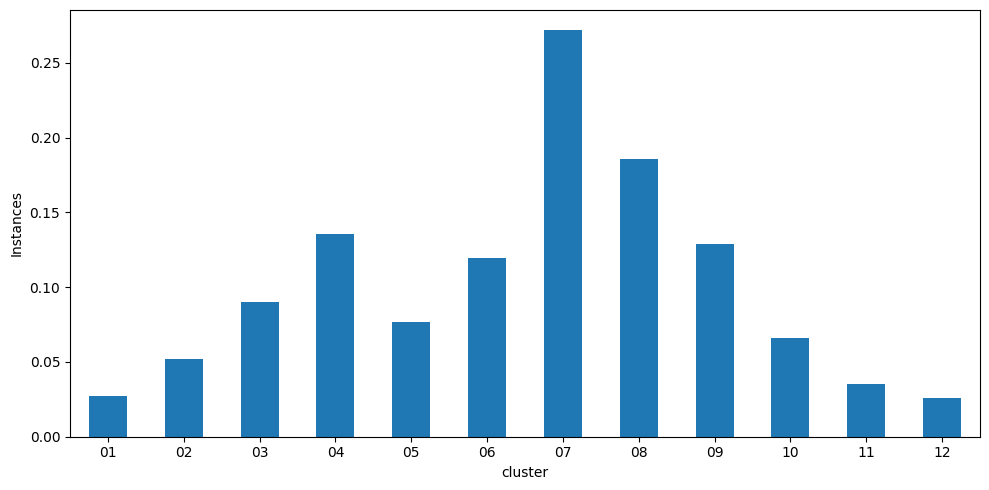

In [ ]:
hist = pd.DataFrame(index=pd.MultiIndex.from_product([train.month.unique()],  names=['month']))
hist.reset_index(inplace=True)
hist.dropna(inplace=True)

gpb = train.groupby(['month'])['calibratedProba'].mean()

fig, ax = plt.subplots(1, figsize = (10,5))
gpb.plot.bar(rot=0, ax=ax)
ax.set_xlabel('cluster')
ax.set_ylabel('Instances')
plt.tight_layout()
plt.show()

In [ ]:
scaler = RobustScaler()

train[variables] = scaler.fit_transform(train[variables])
test[variables] = scaler.transform(test[variables])
val[variables] = scaler.transform(val[variables])

with open(dir_csv / 'scaler_origin.pkl', 'wb') as f:
    pickle.dump(scaler, f)

### Oversampling

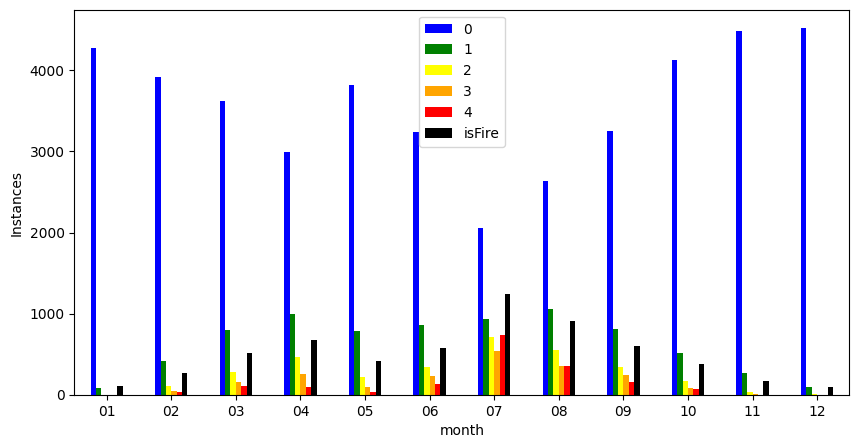

In [ ]:
hist = pd.DataFrame(index=pd.MultiIndex.from_product([dataset.month.unique(), ['0'], ['1'], ['2'], ['3'], ['4'], ['isFire']],  names=['month', '0', '1', '2', '3', '4', 'numFire']))
hist.reset_index(inplace=True)
hist.dropna(inplace=True)

dataset['coef'] = 1

gpb = dataset.groupby(['month', 'classCalibrated'])['coef'].sum()
for index, row in hist.iterrows():
    for c in ['0', '1', '2', '3', '4']:
        try:
            hist.loc[index, c] = gpb.loc[row['month'], int(c)]
        except:
            hist.loc[index, c] = 0

gpb = dataset.groupby(['month'])['isFire'].sum()
for index, row in hist.iterrows():
        vali = gpb.loc[row['month']]
        hist.loc[index, 'isFire'] = vali

hist.index = hist.month
hist.drop('month', axis=1, inplace=True)

fig, ax = plt.subplots(1, figsize = (10,5))
hist.plot.bar(rot=0, color={"0": "blue", "1": "green", "2": "yellow", "3": "orange", "4": "red", 'isFire' : 'black'}, ax=ax)
ax.set_xlabel('month')
ax.set_ylabel('Instances')
plt.show()

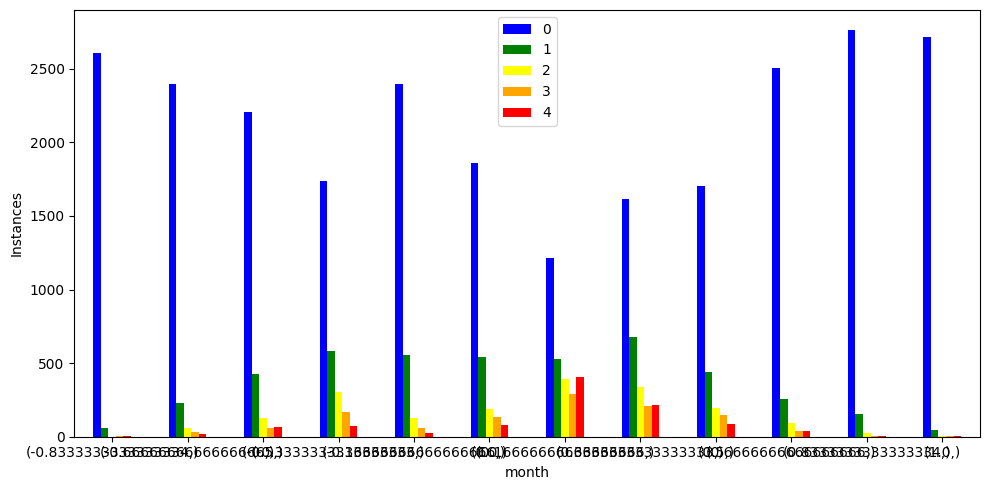

In [ ]:
hist = pd.DataFrame(index=pd.MultiIndex.from_product([train.month.unique(), ['0'], ['1'], ['2'], ['3'], ['4']],  names=['month', '0', '1', '2', '3', '4']))
hist.reset_index(inplace=True)
hist.dropna(inplace=True)

gpb = train.groupby(['month', 'class'])['coef'].sum()
for index, row in hist.iterrows():
    for c in ['0', '1', '2', '3', '4']:
        try:
            hist.loc[index, c] = gpb.loc[row['month'], int(c)]
        except:
            hist.loc[index, c] = 5
            
hist.index = pd.MultiIndex.from_arrays([hist.month])
hist.drop('month', axis=1, inplace=True)
hist.sort_values('month', inplace=True)
fig, ax = plt.subplots(1, figsize = (10,5))
hist.plot.bar(rot=0, color={"0": "blue", "1": "green", "2": "yellow", "3": "orange", "4": "red"}, ax=ax)
ax.set_xlabel('month')
ax.set_ylabel('Instances')
plt.tight_layout()
plt.show()

In [ ]:
def re_discretize(discrete_values, values_to_discretize):

    insertion_index = np.searchsorted(discrete_values, values_to_discretize)
 
    index_closest_lower = (insertion_index - 1).clip(min=0)
    index_closest_upper = insertion_index.clip(max=len(discrete_values) - 1)


    closest_indexes = np.vstack((index_closest_lower, index_closest_upper))
    closest_values = np.take(discrete_values, closest_indexes)
    shortest_distances = abs(closest_values - values_to_discretize)

    nearest_value = shortest_distances.argmin(axis=0)
    discretized_values = closest_values[
        nearest_value, np.arange(len(values_to_discretize))
    ]

    return discretized_values


discreteVar = ['Canicule', 'match_LGF1',
            'match_CL',
            'match_LGF1-2',
            'match_LGF1-4',
            'match_LGF1-6',
            'match_LGF1-8',
            'match_LGF1-10',
            'match_LGF1-12',
            'match_CL-2',
            'match_CL-4',
            'match_CL-6',
            'match_CL-8',
            'match_CL-10',
            'match_CL-12', 'bankHolidays', 'bankHolidaysEve', 'bankHolidaysEveEve', 'holidays',
            'holidaysEve', 'holidaysEveEve', 'holidaysLastDay', 'holidaysLastLastDay', 'confinement1', 'confinement2', 'ramadan', 'dayofweek',
            'month', 'dayofyear']


In [ ]:
gpb = train.groupby(['class'])['coef'].sum()
gpb

class
0    25716
1     4497
2     1864
3     1135
4     1013
Name: coef, dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline
import smogn

train_copy = train.copy(deep=True)
train_reg = train.copy(deep=True)
train_binary = train.copy(deep=True)
train_multi_class = train.copy(deep=True)

"""n_instance = len(train[train['isFire'] == 1])
pipe = make_pipeline(NearMiss(sampling_strategy={0: n_instance}))
## BINARY
X_res, y_res = pipe.fit_resample(train_binary[variables], train_binary['isFire'])

train_binary = X_res
train_binary['isFire'] = y_res.values

## MULTI CLASS
pipe = make_pipeline(SMOTE(sampling_strategy={2: n_instance, 3: n_instance, 4: n_instance}), NearMiss(sampling_strategy={0:n_instance, 1: n_instance}))

temp = variables
temp.append('calibratedProba')
maxProba = train_reg['calibratedProba'].max()

X_res, y_res = pipe.fit_resample(train_multi_class[temp], train_multi_class['classCalibrated'])

train_multi_class = X_res
train_multi_class['class'] = y_res.values
test['class'] = test['classCalibrated']
val['class'] = val['classCalibrated']"""

"""
temp.append('calibratedProba')

train_reg_ = smogn.smoter(
    
   ## primary arguments / inputs
    train_reg[temp],                     ## training set  (pandas dataframe)
    'calibratedProba',                        ## response variable y by name  (string)
    k = 5,                    ## num of neighs for over-sampling  (pos int)
    samp_method = "balance",  ## % over / under sample  ("balance" or extreme")
)

kmeansClass = pickle.load(open(dir_csv / 'classifier_calibrated.pkl', 'rb'))
kcc = np.sort(kmeansClass.cluster_centers_.reshape(-1))
n_class = 5
kcc2class = {}
value4class = {}
#test['weights'] = test['isFire'].apply(lambda x : fireWeight[x])

def get_class_center(cluster):
    #cluster = kmeansClass.predict([[x]])[0]
    return kmeansClass.cluster_centers_[cluster][0]"""

#train_reg = X_res
#train_reg['calibratedProba'] = X_res['calibratedProba']
#train_reg['calibratedProba'] = X_res['class'].apply(get_class_center)
#print(train_reg.min(), train_reg.max())

"""for discrete_var in discreteVar:
    train_multi_class[discrete_var] = re_discretize(np.unique(train_copy[discrete_var]), train_multi_class[discrete_var].values)
    train_binary[discrete_var] = re_discretize(np.unique(train_copy[discrete_var]), train_binary[discrete_var].values)
    #train_reg[discrete_var] = re_discretize(np.unique(train_copy[discrete_var]), train_reg[discrete_var].values)
    print(discrete_var, np.unique(train_copy[discrete_var]), np.unique(train_binary[discrete_var]), np.unique(train_multi_class[discrete_var]), np.unique(train_reg[discrete_var]))
"""
train_multi_class['weights'] = train_multi_class['class'].apply(lambda x : classWeight[x])
train_reg['weights'] = train_reg['class'].apply(lambda x : classWeight[x])

train_binary['weights_binary'] = train_binary['isFire'].apply(lambda x : fireWeight[x])
train_binary['weights_regressive'] = train_binary['class'].apply(lambda x : classWeight[x])

test['weights_binary'] = test['isFire'].apply(lambda x : fireWeight[x])
test['weights_regressive'] = test['class'].apply(lambda x : classWeight[x])

val['weights_binary'] = test['isFire'].apply(lambda x : fireWeight[x])
val['weights_regressive'] = test['class'].apply(lambda x : classWeight[x])

val.to_csv(dir_csv / 'val.csv')
test.to_csv(dir_csv / 'test.csv')

train_binary.to_csv(dir_csv / 'train.csv', index=False)
#train_reg.to_csv(dir_csv / 'train_reg.csv', index=False)
#train_multi_class.to_csv(dir_csv / 'train_multi_class.csv', index=False)

/tmp/ipykernel_89639/2842632766.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['weights_binary'] = test['isFire'].apply(lambda x : fireWeight[x])
/tmp/ipykernel_89639/2842632766.py:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['weights_regressive'] = test['class'].apply(lambda x : classWeight[x])
/tmp/ipykernel_89639/2842632766.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns a

In [ ]:
loglossProba = np.zeros(shape=(len(test), 2))
loglossProba[:,0] = 1 - test['calibratedProba'].values
loglossProba[:,1] = test['calibratedProba'].values

print(log_loss(test['isFire'].values, loglossProba, sample_weight=test['weights']))

loglossProba = np.zeros(shape=(len(test[test['isFire'] == 1]), 2))
loglossProba[:,0] = 1 - test[test['isFire'] == 1]['calibratedProba'].values
loglossProba[:,1] = test[test['isFire'] == 1]['calibratedProba'].values

print(log_loss(test[test['isFire'] == 1]['isFire'].values, loglossProba, sample_weight=test[test['isFire'] == 1]['weights'], labels=[0,1]))

0.681481376061247
1.2415070905354835


In [ ]:
classWeight

{0: 1.0,
 1: 5.753280839895013,
 2: 13.602233943530871,
 3: 21.821801891488303,
 4: 25.518044237485448}

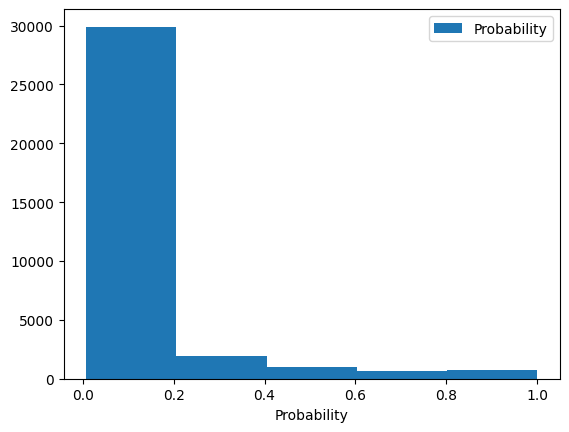

In [ ]:
hist = plt.hist(train_reg['calibratedProba'], bins=5, label='Probability')
hist = hist[0]
plt.xlabel('Probability')
plt.legend()

In [ ]:
train_multi_class['coef'] = 1
gpb = train_multi_class.groupby(['class'])['coef'].sum()
gpb

class
0    25716
1     4497
2     1864
3     1135
4     1013
Name: coef, dtype: int64

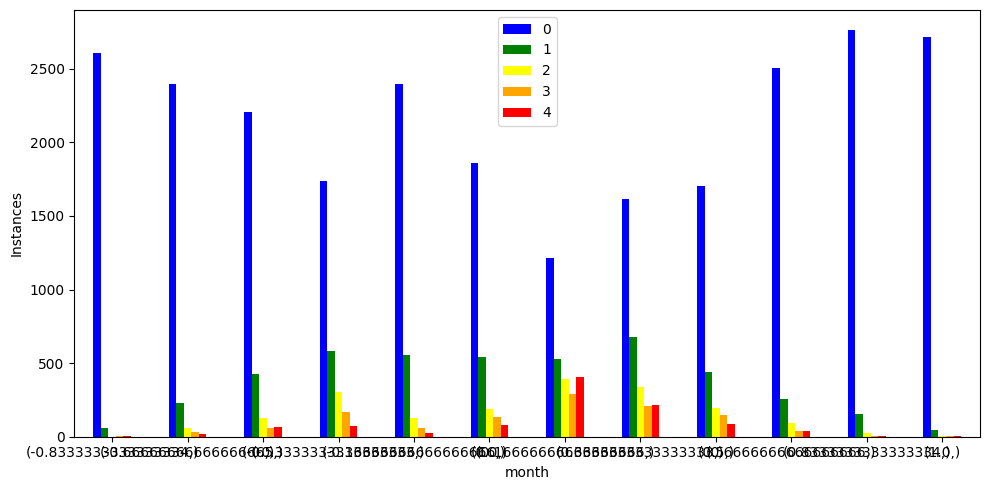

In [ ]:
hist = pd.DataFrame(index=pd.MultiIndex.from_product([train_multi_class.month.unique(), ['0'], ['1'], ['2'], ['3'], ['4']],  names=['month', '0', '1', '2', '3', '4']))
hist.reset_index(inplace=True)
hist.dropna(inplace=True)

gpb = train_multi_class.groupby(['month', 'class'])['coef'].sum()
for index, row in hist.iterrows():
    for c in ['0', '1', '2', '3', '4']:
        try:
            hist.loc[index, c] = gpb.loc[row['month'], int(c)]
        except:
            hist.loc[index, c] = 5
            
hist.index = pd.MultiIndex.from_arrays([hist.month])
hist.drop('month', axis=1, inplace=True)
hist.sort_values('month', inplace=True)
fig, ax = plt.subplots(1, figsize = (10,5))
hist.plot.bar(rot=0, color={"0": "blue", "1": "green", "2": "yellow", "3": "orange", "4": "red"}, ax=ax)
ax.set_xlabel('month')
ax.set_ylabel('Instances')
plt.tight_layout()
plt.show()

<Axes: xlabel='isFire'>

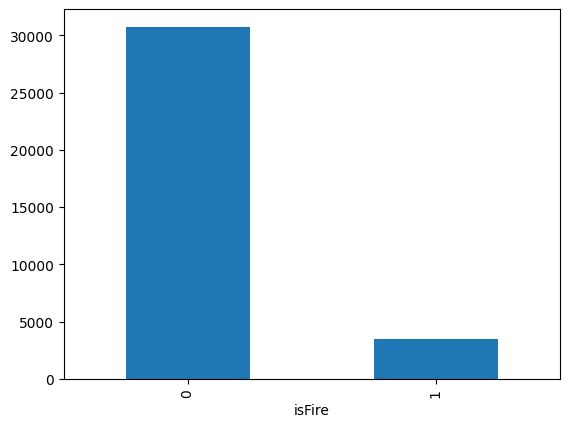

In [ ]:
train_binary['coef'] = 1
gpb = train_binary.groupby('isFire')['coef'].sum()
gpb.plot.bar()

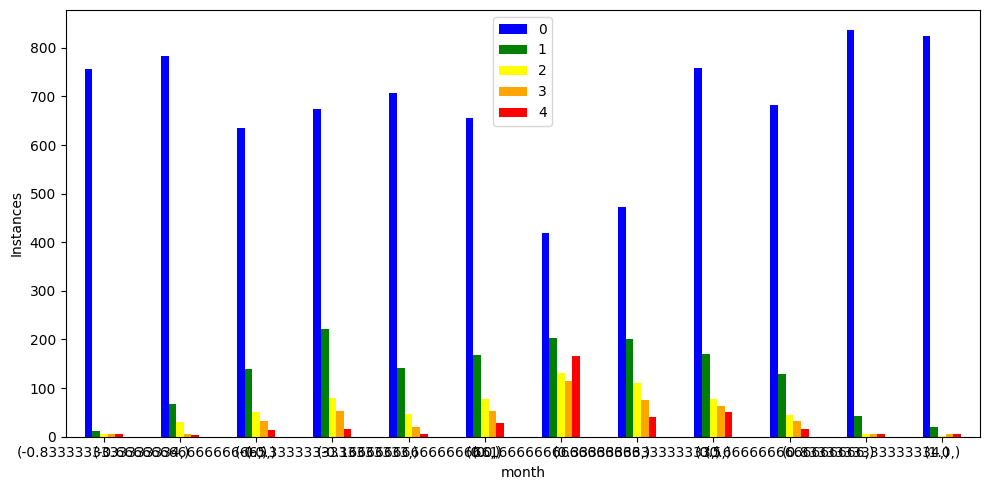

In [ ]:
hist = pd.DataFrame(index=pd.MultiIndex.from_product([test.month.unique(), ['0'], ['1'], ['2'], ['3'], ['4']],  names=['month', '0', '1', '2', '3', '4']))
hist.reset_index(inplace=True)
hist.dropna(inplace=True)

gpb = test.groupby(['month', 'class'])['coef'].sum()
for index, row in hist.iterrows():
    for c in ['0', '1', '2', '3', '4']:
        try:
            hist.loc[index, c] = gpb.loc[row['month'], int(c)]
        except:
            hist.loc[index, c] = 5
            
hist.index = pd.MultiIndex.from_arrays([hist.month])
hist.drop('month', axis=1, inplace=True)
hist.sort_values('month', inplace=True)
fig, ax = plt.subplots(1, figsize = (10,5))
hist.plot.bar(rot=0, color={"0": "blue", "1": "green", "2": "yellow", "3": "orange", "4": "red"}, ax=ax)
ax.set_xlabel('month')
ax.set_ylabel('Instances')
plt.tight_layout()
plt.show()

In [ ]:
classes =  [0,1,2,3,4]
meanfireday = {}
percentfire = {}
percentfireInfire = {}

meanfiredayfwi = {}
percentfirefwi = {}
percentfireInfirefwi = {}

percentmean = 0
percentmeanfwi = 0

for c in classes:
    percentfire[c] = (test[(test['classCalibrated'] == c) & (test['isFire'] == 1)]['isFire'].sum() / test[(test['classCalibrated'] == c)]['coef'].sum()) * 100
    percentfireInfire[c] = test[(test['classCalibrated'] == c) & (test['isFire'] == 1)]['isFire'].sum() / test[(test['isFire'] == 1)]['coef'].sum() * 100

meanfireday, percentfire, percentmean, percentfireInfire

({},
 {0: 1.840116987570071,
  1: 21.39565503620803,
  2: 35.47400611620795,
  3: 52.328159645232816,
  4: 72.94117647058823},
 0,
 {0: 12.667785234899329,
  1: 27.265100671140942,
  2: 19.463087248322147,
  3: 19.798657718120804,
  4: 20.80536912751678})

<Axes: xlabel='isFire'>

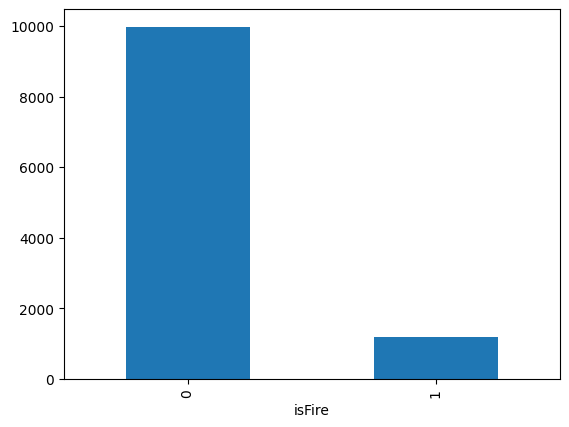

In [ ]:
gpb = test.groupby('isFire')['coef'].sum()
gpb.plot.bar()

In [ ]:
calibratedProba.max()

1.0

/tmp/ipykernel_89639/391658181.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("Dark2")


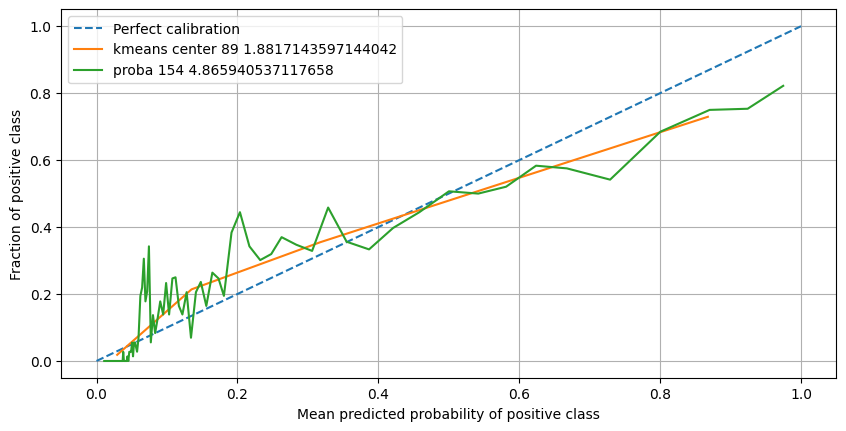

In [ ]:
from sklearn.linear_model import LogisticRegression
from matplotlib.gridspec import GridSpec

test['calibratedProba'] = test['calibratedProba'].apply(lambda x : x if x > 0 else 0)

calibratedProba = test['calibratedProba'].values
classCenter = test['classCalibratedProba'].values

fig = plt.figure(figsize=(10,10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
ax_calibration_curve.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect calibration')
n_bins, ece = expected_calibration_error(test['isFire'], classCenter, bins='auto')
y_means, proba_means = calibration_curve(test['isFire'], classCenter, n_bins=n_bins, strategy='quantile')
ax_calibration_curve.plot(proba_means, y_means, label='kmeans center ' + str(n_bins) + " " + str(ece))

n_bins, ece = expected_calibration_error(test['isFire'], calibratedProba, bins='auto')
y_means, proba_means = calibration_curve(test['isFire'], calibratedProba, n_bins=n_bins, strategy='quantile')
ax_calibration_curve.plot(proba_means, y_means, label='proba ' + str(n_bins) + " " + str(ece))

ax_calibration_curve.set(xlabel="Mean predicted probability of positive class", ylabel="Fraction of positive class")
ax_calibration_curve.grid()
ax_calibration_curve.legend()

plt.savefig(dir_csv / 'calibration_study_test.png')

### Val

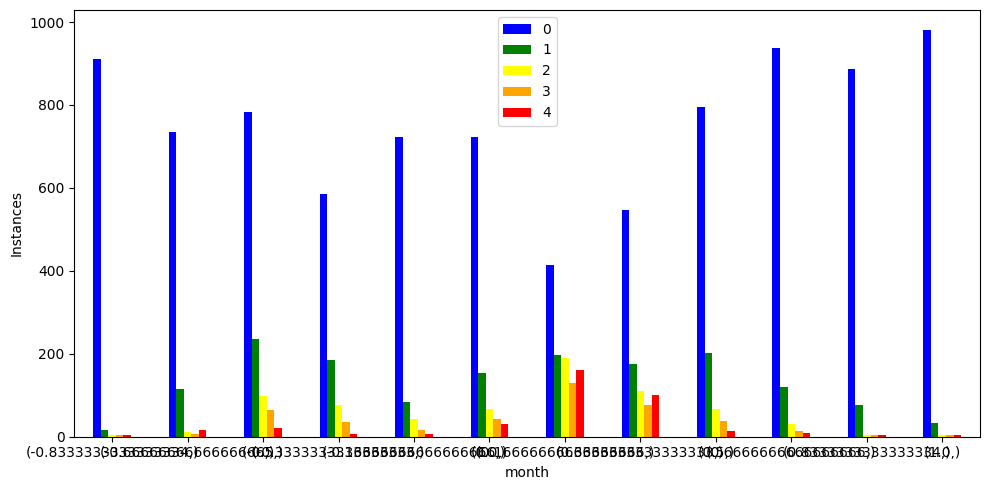

In [ ]:
hist = pd.DataFrame(index=pd.MultiIndex.from_product([val.month.unique(), ['0'], ['1'], ['2'], ['3'], ['4']],  names=['month', '0', '1', '2', '3', '4']))
hist.reset_index(inplace=True)
hist.dropna(inplace=True)

gpb = val.groupby(['month', 'class'])['coef'].sum()

for index, row in hist.iterrows():
    for c in ['0', '1', '2', '3', '4']:
        try:
            hist.loc[index, c] = gpb.loc[row['month'], int(c)]
        except:
            hist.loc[index, c] = 5
            
hist.index = pd.MultiIndex.from_arrays([hist.month])
hist.drop('month', axis=1, inplace=True)
hist.sort_values('month', inplace=True)
fig, ax = plt.subplots(1, figsize = (10,5))
hist.plot.bar(rot=0, color={"0": "blue", "1": "green", "2": "yellow", "3": "orange", "4": "red"}, ax=ax)
ax.set_xlabel('month')
ax.set_ylabel('Instances')
plt.tight_layout()
plt.show()

In [ ]:
classes =  [0,1,2,3,4]
meanfireday = {}
percentfire = {}
percentfireInfire = {}

meanfiredayfwi = {}
percentfirefwi = {}
percentfireInfirefwi = {}

percentmean = 0
percentmeanfwi = 0

for c in classes:
    percentfire[c] = (val[(val['classCalibrated'] == c) & (val['isFire'] == 1)]['isFire'].sum() / val[(val['classCalibrated'] == c)]['coef'].sum()) * 100
    percentfireInfire[c] = val[(val['classCalibrated'] == c) & (val['isFire'] == 1)]['isFire'].sum() / val[(val['isFire'] == 1)]['coef'].sum() * 100

meanfireday, percentfire, percentmean, percentfireInfire

({},
 {0: 1.8951568214562782,
  1: 23.884349465744815,
  2: 34.42389758179232,
  3: 55.7919621749409,
  4: 71.78082191780823},
 0,
 {0: 13.245546088303643,
  1: 29.434546862896976,
  2: 18.745158791634392,
  3: 18.28040278853602,
  4: 20.29434546862897})

<Axes: xlabel='isFire'>

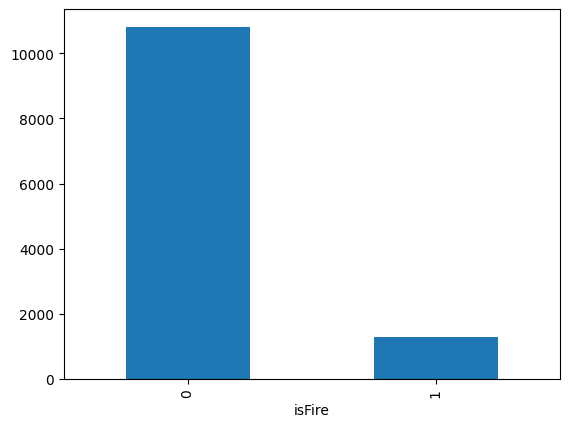

In [ ]:
gpb = val.groupby('isFire')['coef'].sum()
gpb.plot.bar()

/tmp/ipykernel_89639/983618949.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("Dark2")


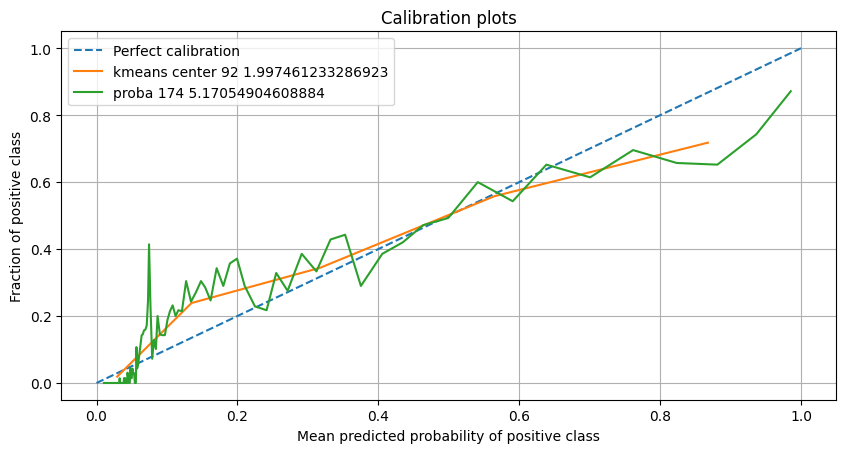

In [ ]:
from sklearn.linear_model import LogisticRegression
from matplotlib.gridspec import GridSpec

val['calibratedProba'] = val['calibratedProba'].apply(lambda x : x if x > 0 else 0)
calibratedProba = val['calibratedProba'].values
classCenter = val['classCalibratedProba'].values

fig = plt.figure(figsize=(10,10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
ax_calibration_curve.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect calibration')
n_bins, ece = expected_calibration_error(val['isFire'], classCenter, bins='auto')
y_means, proba_means = calibration_curve(val['isFire'], classCenter, n_bins=n_bins, strategy='quantile')
ax_calibration_curve.plot(proba_means, y_means, label='kmeans center ' + str(n_bins) + " " + str(ece))

n_bins, ece = expected_calibration_error(val['isFire'], calibratedProba, bins='auto')
y_means, proba_means = calibration_curve(val['isFire'], calibratedProba, n_bins=n_bins, strategy='quantile')
ax_calibration_curve.plot(proba_means, y_means, label='proba ' + str(n_bins) + " " + str(ece))

ax_calibration_curve.set(xlabel="Mean predicted probability of positive class", ylabel="Fraction of positive class")
ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")
ax_calibration_curve.legend()

plt.savefig(dir_csv / 'calibration_study_val.png')